# Data cleaning
## Perform data cleaning, outliers removal

In [1]:
# Doing all imports and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv("house-prices.csv")
df_test = pd.read_csv("house-prices-test.csv")
initial_rows_count = df.shape[0]
initial_columns_count = df.shape[1]
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


Storing `PID` of test dataframe to be able to generate predictions CSVs. Storing also mean `SalePrice` from training dataframe.

In [3]:
df_pred = df_test.PID

In [4]:
avg_SalePrice = df['SalePrice'].mean()

### Context 
We get it from (https://jse.amstat.org/v19n3/decock.pdf). In this notebook, the text after "Hint:" in a separate markdown cell is directly extracted from this PDF.

Hint: This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.
* If a property was sold multiply times during 4 year period, only last sale record has been kept
* Only residential sales are in dataset (no stand-alone garages, condos, and storage areas)

Base on the documentation, we define a dictionnary to easily retrieve features description and feature type

In [5]:
# Define lists containing feature information
# Extracted in Excel from documentation.txt (using text to columns and textjoin())
feature_names = ['Order','PID','MS SubClass','MS Zoning','Lot Frontage','Lot Area','Street','Alley','Lot Shape','Land Contour','Utilities','Lot Config','Land Slope','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Overall Qual','Overall Cond','Year Built','Year Remod/Add','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Mas Vnr Area','Exter Qual','Exter Cond','Foundation','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','Heating','Heating QC','Central Air','Electrical','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','Kitchen Qual','TotRms AbvGrd','Functional','Fireplaces','Fireplace Qu','Garage Type','Garage Yr Blt','Garage Finish','Garage Cars','Garage Area','Garage Qual','Garage Cond','Paved Drive','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Pool QC','Fence','Misc Feature','Misc Val','Mo Sold','Yr Sold','Sale Type','Sale Condition']
feature_types = ['Discrete','Nominal','Nominal','Nominal','Continuous','Continuous','Nominal','Nominal','Ordinal','Nominal','Ordinal','Nominal','Ordinal','Nominal','Nominal','Nominal','Nominal','Nominal','Ordinal','Ordinal','Discrete','Discrete','Nominal','Nominal','Nominal','Nominal','Nominal','Continuous','Ordinal','Ordinal','Nominal','Ordinal','Ordinal','Ordinal','Ordinal','Continuous','Ordinal','Continuous','Continuous','Continuous','Nominal','Ordinal','Nominal','Ordinal','Continuous','Continuous','Continuous','Continuous','Discrete','Discrete','Discrete','Discrete','Discrete','Discrete','Ordinal','Discrete','Ordinal','Discrete','Ordinal','Nominal','Discrete','Ordinal','Discrete','Continuous','Ordinal','Ordinal','Ordinal','Continuous','Continuous','Continuous','Continuous','Continuous','Continuous','Ordinal','Ordinal','Nominal','Continuous','Discrete','Discrete','Nominal','Nominal']
feature_descriptions = ['Observation number','Parcel identification number - can be used with city web site for parcel review.','Identifies the type of dwelling involved in the sale.','Identifies the general zoning classification of the sale.','Linear feet of street connected to property','Lot size in square feet','Type of road access to property','Type of alley access to property','General shape of property','Flatness of the property','Type of utilities available','Lot configuration','Slope of property','Physical locations within Ames city limits (map available)','Proximity to various conditions','Proximity to various conditions (if more than one is present)','Type of dwelling','Style of dwelling','Rates the overall material and finish of the house','Rates the overall condition of the house','Original construction date','Remodel date (same as construction date if no remodeling or additions)','Type of roof','Roof material','Exterior covering on house','Exterior covering on house (if more than one material)','Masonry veneer type','Masonry veneer area in square feet','Evaluates the quality of the material on the exterior','Evaluates the present condition of the material on the exterior','Type of foundation','Evaluates the height of the basement','Evaluates the general condition of the basement','Refers to walkout or garden level walls','Rating of basement finished area','Type 1 finished square feet','Rating of basement finished area (if multiple types)','Type 2 finished square feet','Unfinished square feet of basement area','Total square feet of basement area','Type of heating','Heating quality and condition','Central air conditioning','Electrical system','First Floor square feet','Second floor square feet','Low quality finished square feet (all floors)','Above grade (ground) living area square feet','Basement full bathrooms','Basement half bathrooms','Full bathrooms above grade','Half baths above grade','Bedrooms above grade (does NOT include basement bedrooms)','Kitchens above grade','Kitchen quality','Total rooms above grade (does not include bathrooms)','Home functionality (Assume typical unless deductions are warranted)','Number of fireplaces','Fireplace quality','Garage location','Year garage was built','Interior finish of the garage','Size of garage in car capacity','Size of garage in square feet','Garage quality','Garage condition','Paved driveway','Wood deck area in square feet','Open porch area in square feet','Enclosed porch area in square feet','Three season porch area in square feet','Screen porch area in square feet','Pool area in square feet','Pool quality','Fence quality','Miscellaneous feature not covered in other categories','$Value of miscellaneous feature','Month Sold (MM)','Year Sold (YYYY)','Type of sale','Condition of sale']

# Create an empty dictionary to store feature information
features_dict = {}

# Iterate through lists and add key-value pairs to dictionary
for i in range(len(feature_names)):
    feature_name = feature_names[i]
    feature_type = feature_types[i]
    feature_description = feature_descriptions[i]
    features_dict[feature_name] = {'feature_type': feature_type, 'feature_desc': feature_description}

In [6]:
# Unique feature types
list(set(feature_types))

['Discrete', 'Ordinal', 'Nominal', 'Continuous']

Hint: There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of `SalePrice` versus `Gr Liv Area` will quickly indicate these points). 
* Three of them are true outliers (Partial Sales that likely don’t represent actual market values)
* Two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.

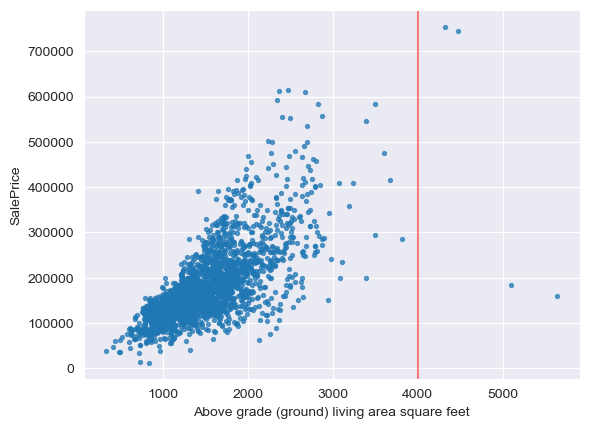

In [7]:
plt.scatter(df['Gr Liv Area'] , df.SalePrice, alpha=0.7, s=8)
plt.axvline(x=4000, color='red', alpha = 0.5)
plt.xlabel("Above grade (ground) living area square feet")
plt.ylabel("SalePrice")
plt.show()

As hinted, the properties with more than 4000 are clear outliers. We remove them from dataframe.
note 4000 square feet is approximatively 372 Square meters.

In [8]:
above_4000_livingarea = (df['Gr Liv Area'] > 4000)
df = df[~above_4000_livingarea]

#### Check for any duplicates rows

In [9]:
# Use the duplicated method to find duplicated rows
duplicated_rows = df[df.duplicated()]
duplicated_rows.size

0

In [10]:
# Checking duplicated rows based on PID
df.PID.duplicated().sum()

0

There is no need for duplicates renewal in training/validation data.

#### Checking skewness of variables

We inspect Skewness of variables before dealing with missing values, not to be influenced by a lot of zeros. We define a custom function for reusability. We remove discrete features to only inspect continuous features

In [11]:
discrete_features = [key for key, value in features_dict.items() if value.get('feature_type') == 'Discrete']

In [12]:
def check_skewness(df):
    """
    Function to check for skewness in a dataframe's columns.
    Plots histograms of the columns to visually inspect skewness.
    Columns with skewness > 1 are potential candidates for transformation.    
    """
    # Number of charts horizontally
    TOTAL_WIDTH = 5
    # Select only numerical columns
    features = list(df.select_dtypes(include='number').columns)
    # Keep only continuous columns as we are inspecting skewness
    features = [feature for feature in features if feature not in discrete_features]
    df_skew = df[features]
    
    # Keep only columns with skweness greater than 
    skewed_cols = [col for col in df_skew.columns if df_skew[col].skew() > 1]
    df_skew = df_skew[skewed_cols]
    
    if df_skew.empty:
        print("No columns with skewness > 1")
    else:
            
        # Calculate the number of rows needed to fit all the charts
        total_height = df_skew.shape[1] // TOTAL_WIDTH
        figure_height = df_skew.shape[1] / TOTAL_WIDTH * 2

        # Check if there are any extra columns that don't fit evenly into a full row
        if df_skew.shape[1] % TOTAL_WIDTH != 0:
        # If there are extra columns, we need an additional row
            total_height += 1

        fig, axes = plt.subplots(total_height,
                                 TOTAL_WIDTH,
                                 figsize=(2*TOTAL_WIDTH,figure_height))
        axes = axes.ravel()


        for i, col in enumerate(df_skew.columns):
            skewness = df[col].skew()
            axes[i].hist(df[col],bins=30)
            # Set the title of the subplot, small labels for readability
            axes[i].set_title(f'{col} {skewness:.2f}',fontdict={'fontsize': 8})
        
        plt.tight_layout()
        
        # Cleaning of unused axes
        for ax in axes.flatten():
            if not ax.has_data():
                ax.remove()
        plt.show()      

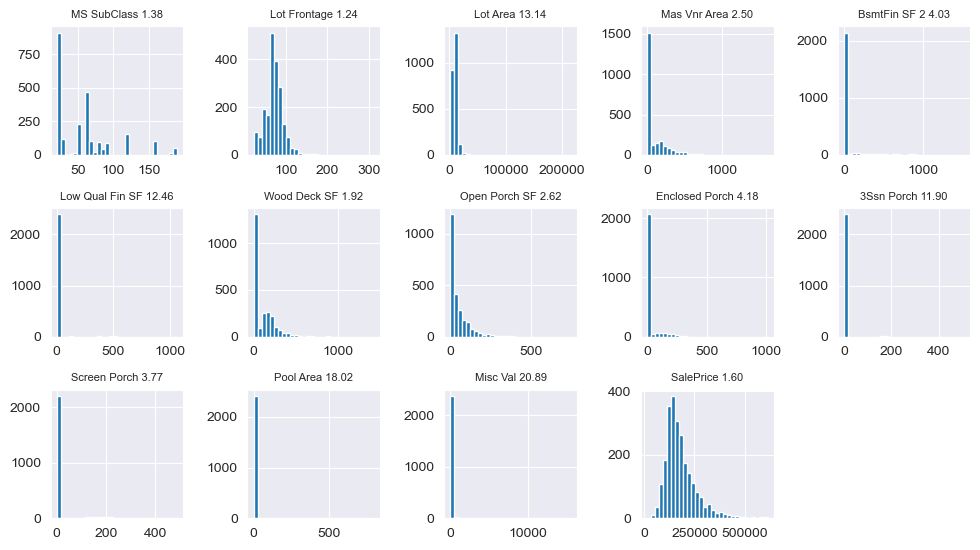

In [13]:
check_skewness(df)

Good candidates for transformations based on visualization
* Dependent variable `SalePrice`
* `Lot Frontage`
* `Lot Area`
* `Mas Vnr Area`
* `Wood Deck SF`
* `Open Porch SF`


After doing a bunch of research (example here https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros) we find that when dealing with zeros one good ideas is to take sqrt transformation. We define a custom function to test every column and plot side to side log and sqrt transformation and select best candidates for normal distribution.

In [14]:
def transform_and_test_normality(df, column):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(7,2))

    axes[0].hist(df[column],bins=30)
    axes[0].set_title(column)    
    
    axes[1].hist(np.log(df[df[column]>0][column]),bins=30)
    title = 'log_'+column
    if df[df[column]==0][column].shape[0]>0:
        title = 'warning, null values'
    axes[1].set_title(title)

    axes[2].hist(np.sqrt(df[column]),bins=30)
    axes[2].set_title('sqrt_'+column)

    plt.show()

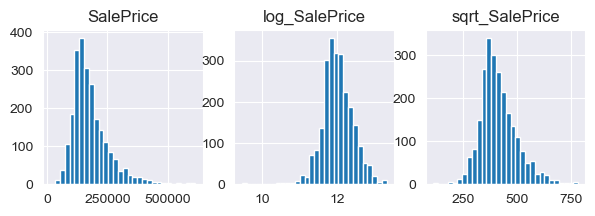

In [15]:
transform_and_test_normality(df,'SalePrice')

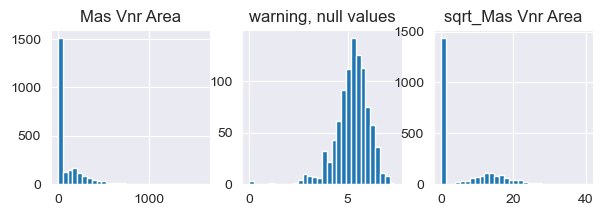

In [16]:
transform_and_test_normality(df,'Mas Vnr Area')

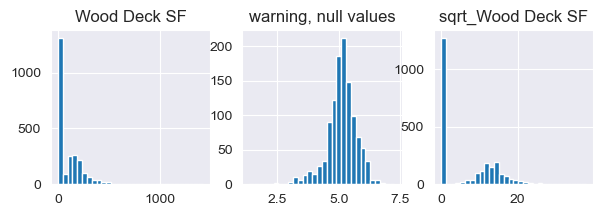

In [17]:
transform_and_test_normality(df,'Wood Deck SF')

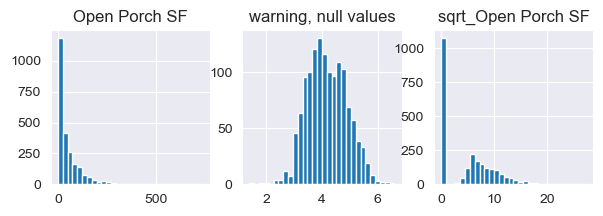

In [18]:
transform_and_test_normality(df,'Open Porch SF')

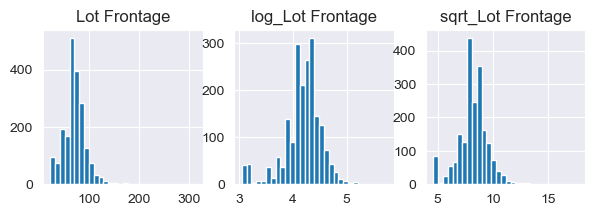

In [19]:
transform_and_test_normality(df,'Lot Frontage')

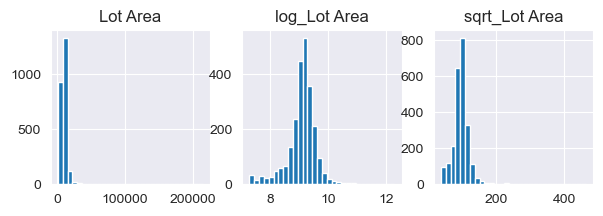

In [20]:
transform_and_test_normality(df,'Lot Area')

After inspection, 
* `SalePrice` is a good candidate for **sqrt transformation**
* `Lot Frontage` and `Lot Area` are good candidates for **Log transformation**
* `Mas Vnr Area`, `Wood Deck SF`, `Open Porch SF` are good candidates to Log transformation if we avoid zeros. After doing some research, example https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros i prefer not to change those feature as they are not cricital feature (size of wood deck or open porch or masonry veneer area), and i don't understand the implications of the different methods.

### Overall Inspection of missing values

Let's illustrate with a red bar on a bar plot

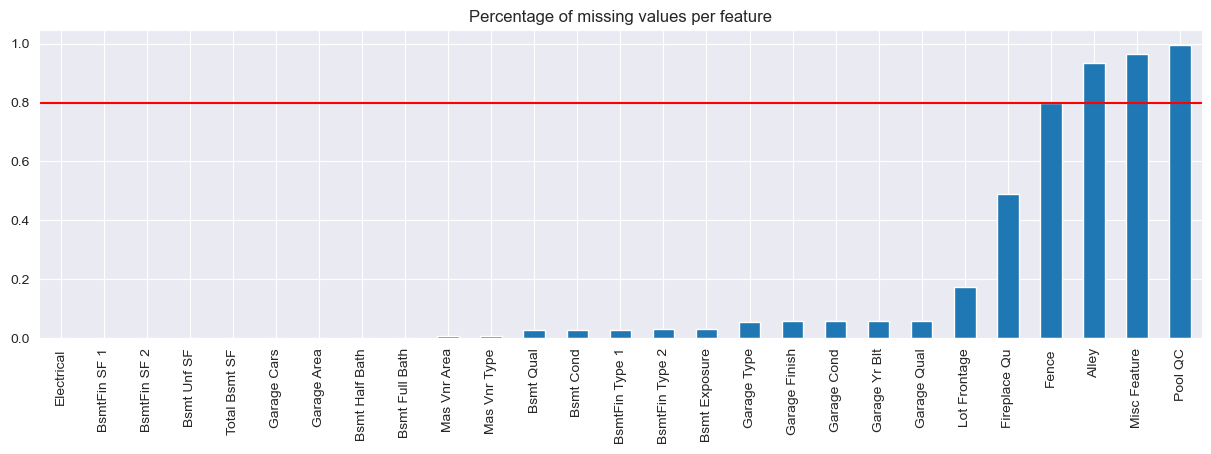

In [21]:
# Defining an arbitrary threshold for the percentage of missing values to remove
remove_feature_threshold = 0.8
df_missing_values_count = df.isna().mean().sort_values()
df_missing_value = df_missing_values_count[df_missing_values_count>0]
df_missing_value.plot(
    kind='bar', figsize=(15, 4), title='Percentage of missing values per feature')

plt.axhline(remove_feature_threshold, color='r') 
plt.show()

* `Fence` and `Alley` have more than 80% missing values and are not related to any other feature, so we will remove them
* `Misc Feature` is only related to `Misc Val` and indicates the price of a miscellaneous feature (in this case the price of the shed included with the house)
* We will not drop `Pool QC` now as it is NA when where is no Pool. One of the idea for later is to check presence of pool and create a new feature if property has a pool. 

Additionally we chose to drop columns`PID` and `Order` as suggested in pdf documentation.

In [22]:
features_to_drop = ['PID',
                    'Order',
                    'Fence',
                    'Alley',
                    'Misc Feature',
                    'Misc Val']

In [23]:
# Remove features from dataframes
df.drop(features_to_drop, axis=1, inplace=True)
df_test.drop(features_to_drop, axis=1, inplace=True)

# Remove entry from features_dict when key is an element of list 'features_to_drop'
features_dict = {k: v for k, v in features_dict.items() if k not in features_to_drop}

#### Discrete features

In [24]:
discrete_features = [key for key, value in features_dict.items() if value.get('feature_type') == 'Discrete']

In [25]:
df[discrete_features].sample(5)

,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold
1970,1960,1960,1.0,0.0,1,0,3,1,7,2,1960.0,2.0,5,2010
159,2007,2008,0.0,0.0,2,0,3,1,6,0,2007.0,2.0,12,2008
2161,1959,1959,0.0,0.0,1,0,3,1,6,0,1959.0,1.0,5,2010
802,2000,2001,0.0,0.0,2,1,3,1,7,1,2000.0,3.0,5,2009
219,2005,2005,0.0,0.0,2,0,3,1,7,1,2005.0,3.0,6,2010


We will take out any time indicator like year built, and order. For other discrete feature we can replace missing values with zeros, because value is missing if you have no associated observation, for example you can have 0 full bath.

In [26]:
discrete_features_nonreplaceable = ['Order', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']
discrete_features_replaceable = [feature for feature in discrete_features if feature not in discrete_features_nonreplaceable]
discrete_features_replaceable

['Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars']

In [27]:
for feature in discrete_features_replaceable:
    # replace missing values in column by 0
    df[feature].fillna(0, inplace=True)
    df_test[feature].fillna(0, inplace=True)

#### Continuous features

In [28]:
continuous_features = [key for key, value in features_dict.items() if value.get('feature_type') == 'Continuous']
df[continuous_features].sample(5)

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area
175,52.0,6240,0.0,48.0,0.0,624.0,672.0,899,423,0,1322,280.0,0,0,0,0,0,0
706,NaN,11200,85.0,1258.0,0.0,40.0,1298.0,1298,0,0,1298,403.0,165,26,0,0,0,0
279,NaN,31220,0.0,0.0,0.0,1632.0,1632.0,1474,0,0,1474,495.0,0,0,144,0,0,0
1484,60.0,8118,178.0,1034.0,0.0,676.0,1710.0,1710,0,0,1710,557.0,156,48,0,0,0,0
977,60.0,7879,0.0,495.0,0.0,225.0,720.0,720,0,0,720,0.0,0,523,115,0,0,0


In [29]:
continuous_features_desc = [value.get('feature_desc') for key, value in features_dict.items() if value.get('feature_type') == 'Continuous']
continuous_features_desc

['Linear feet of street connected to property',
 'Lot size in square feet',
 'Masonry veneer area in square feet',
 'Type 1 finished square feet',
 'Type 2 finished square feet',
 'Unfinished square feet of basement area',
 'Total square feet of basement area',
 'First Floor square feet',
 'Second floor square feet',
 'Low quality finished square feet (all floors)',
 'Above grade (ground) living area square feet',
 'Size of garage in square feet',
 'Wood deck area in square feet',
 'Open porch area in square feet',
 'Enclosed porch area in square feet',
 'Three season porch area in square feet',
 'Screen porch area in square feet',
 'Pool area in square feet']

All continous feature describe an area in square feet. 
All can theorically be zeros (there can be no basement, no pool, no garage, no porch, no masonry veneer.
except
* `Lot Frontage` : we assume a property is always connected to a street (it does not exist of the grid, apart from extreme outliers)
* `Gr Liv Area` and  `1st Flr SF` : this listings are selling above the ground properties. In the US the first floor is the ground floor in Europe.

So we can replace missing values by 0, meaning 0 square feet of feature.

In [30]:
continuous_features_nonreplaceable = ['Lot Frontage', 'Gr Liv Area', '1st Flr SF']
continuous_features_replaceable = [feature for feature in continuous_features if feature not in continuous_features_nonreplaceable]
continuous_features_replaceable

['Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area']

In [31]:
for feature in continuous_features_replaceable:
    # replace missing values in column by 0
    df[feature].fillna(0, inplace=True)
    df_test[feature].fillna(0, inplace=True)

##### Lot Frontage

We will try a variable that is a good explanation. There is two potential variables that explains variation in Lot Frontage
* `Lot Shape` (Ordinal): General shape of property
* `Lot Config` (Nominal): Lot configuration

`Lot Config` seems to a better fit as in documentation in explicitly mentions the Frontage, example values
* FR2	Frontage on 2 sides of property
* FR3	Frontage on 3 sides of property

We try and compare both options and see which one could be a good proxy on which to take mean of `Lot Frontage` for missing values in `Lot Frontage`. 

If a categorical variable is good at summarizing `Lot Frontage`, we translate into the fact that coefficient of variation (std / mean) is low, meaning values are aggregated around the mean.

We caculate this for `Lot Config`, `Lot Shape` and every combinations of (`Lot Config`,`Lot Shape`).

In [32]:
by_config = df.groupby(['Lot Config'])['Lot Frontage'].agg(['count','mean', 'std'])
by_config['varCoef'] = (by_config['std'] / by_config['mean'])

by_shape = df.groupby(['Lot Shape'])['Lot Frontage'].agg(['count','mean', 'std'])
by_shape['varCoef'] = (by_shape['std'] / by_shape['mean'])

by_shape_by_config = df.groupby(['Lot Shape','Lot Config'])['Lot Frontage'].agg(['count','mean', 'std'])
by_shape_by_config.fillna(0, inplace=True)
by_shape_by_config['varCoef'] = (by_shape_by_config['std'] / by_shape_by_config['mean'])

print(by_config)
print(by_shape)
print(by_shape_by_config)

            count       mean        std   varCoef
Lot Config                                       
Corner        327  81.941896  22.468512  0.274201
CulDSac        78  55.923077  22.698915  0.405895
FR2            55  63.327273  29.969154  0.473242
FR3             8  83.000000  34.517077  0.415868
Inside       1538  67.026658  21.299303  0.317774
           count        mean        std   varCoef
Lot Shape                                        
IR1          551   74.528131  23.125087  0.310287
IR2           40   69.625000  49.620450  0.712682
IR3            9  102.444444  57.288985  0.559220
Reg         1406   66.585349  20.392540  0.306262
                      count        mean        std   varCoef
Lot Shape Lot Config                                        
IR1       Corner        106   92.792453  17.866551  0.192543
          CulDSac        62   56.258065  19.643491  0.349168
          FR2            11   74.727273  45.558953  0.609670
          FR3             4   87.500000  32.9

Coefficients are slightly lower lower if we take both `Lot Shape` and `Lot Config` into consideration on combinations with most records. We will replace missing values in `Lot frontage` by Mean of `Lot frontage` in same `Lot shape` `Lot Config` combinations

In [33]:
grouped = df.groupby(['Lot Shape','Lot Config'])

# This time we group as integer as Lot Frontage is an integer
mean_frontage = grouped['Lot Frontage'].mean().astype(int).reset_index()

# Rename columns to prepare for merge 
mean_frontage.columns = ['Lot Shape','Lot Config','mean_frontage']

# Merge mean_values with original dataframes
df = pd.merge(df, mean_frontage, on=['Lot Shape','Lot Config'], how='left')
df_test = pd.merge(df_test, mean_frontage, on=['Lot Shape','Lot Config'], how='left')

# Replace missing values by mean calculated on Shape and Config
df['Lot Frontage'].fillna(df['mean_frontage'], inplace=True)
df_test['Lot Frontage'].fillna(df_test['mean_frontage'], inplace=True)

# Drop mean_frontage column as it is no longer useful
df.drop(['mean_frontage'], axis=1, inplace=True)
df_test.drop(['mean_frontage'], axis=1, inplace=True)

Additionally, we saw before that `Lot Frontage` was a good candidate for log transformation, so we apply it. Same for `Lot Area`

In [34]:
df['log_LotFrontage'] = np.log(df['Lot Frontage'])
df_test['log_LotFrontage'] = np.log(df_test['Lot Frontage'])

In [35]:
df['log_LotArea'] = np.log(df['Lot Area'])
df_test['log_LotArea'] = np.log(df_test['Lot Area'])

#### Ordinal features

##### Basement example

In [36]:
bsmt_columns = [column for column in df.columns if 'Bsmt' in column]
df_bsmt = df[bsmt_columns]
bsmt_na = df[bsmt_columns].isna().any(axis=1)
             
df_bsmt[bsmt_na].sample(5)

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1452,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1225,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2137,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
48,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
872,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0


We see quite clearly, and this is also explicit in documentation, that Basement Columns are missing when there is no Basement. 

We generalize and replace missing values by 'Absent'. We will have a step of retreating ordinal features for feature engineering anyway. We replace by absent even knowing that in documentation some features are treated slightly differently
examples
* `Bsmt Exposure`: get a no category 'No	No Exposure'. 'No' and 'Absent' will be 0 in scale.
* `BsmtFin Type 1` : does not have a no Category. 'Absent' will be 0 in scale .

In [37]:
ordinal_features = [key for key, value in features_dict.items() if value.get('feature_type') == 'Ordinal']

In [38]:
ordinal_features

['Lot Shape',
 'Utilities',
 'Land Slope',
 'Overall Qual',
 'Overall Cond',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating QC',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC']

In [39]:
for feature in ordinal_features:
    # Replace missing values in column by 'Absent'
    df[feature].fillna('Absent', inplace=True)
    df_test[feature].fillna('Absent', inplace=True)

#### Nominal features

In [40]:
nominal_features = [key for key, value in features_dict.items() if value.get('feature_type') == 'Nominal']
df[nominal_features].sample(5)

,MS SubClass,MS Zoning,Street,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,...,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Sale Type,Sale Condition
1904,90,RL,Pave,Lvl,Inside,Sawyer,Norm,Norm,Duplex,1Story,...,CompShg,Plywood,Plywood,BrkFace,CBlock,GasA,Y,Attchd,WD,Normal
8,60,RL,Pave,HLS,CulDSac,Gilbert,Norm,Norm,1Fam,2Story,...,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,Attchd,WD,Normal
1881,20,RM,Pave,Lvl,Inside,OldTown,Norm,Norm,1Fam,1Story,...,CompShg,MetalSd,MetalSd,None,BrkTil,GasA,Y,NaN,WD,Abnorml
1615,60,RL,Pave,Lvl,Inside,NAmes,PosN,Norm,1Fam,2Story,...,CompShg,VinylSd,VinylSd,BrkFace,CBlock,GasA,Y,Attchd,WD,Normal
1472,50,RL,Pave,Lvl,Inside,NoRidge,Norm,Norm,1Fam,1.5Fin,...,CompShg,HdBoard,HdBoard,BrkFace,PConc,GasA,Y,Attchd,WD,Normal


In [41]:
df[nominal_features].isna().mean().sort_values()

MS SubClass       0.000000
Central Air       0.000000
Heating           0.000000
Foundation        0.000000
Exterior 2nd      0.000000
Exterior 1st      0.000000
Roof Matl         0.000000
Sale Type         0.000000
House Style       0.000000
Roof Style        0.000000
Condition 2       0.000000
Condition 1       0.000000
Neighborhood      0.000000
Lot Config        0.000000
Land Contour      0.000000
Street            0.000000
MS Zoning         0.000000
Bldg Type         0.000000
Sale Condition    0.000000
Mas Vnr Type      0.008244
Garage Type       0.056059
dtype: float64

* Mas Vnr Type (Nominal): Masonry veneer type > already has a missing value 'None' that we re-use 

In [42]:
feature = 'Mas Vnr Type'
fill_value = 'None'
df[feature].fillna(fill_value, inplace=True)
df_test[feature].fillna(fill_value, inplace=True)

* Garage Type : Garage Type (Nominal): Garage location > has no missing value, we will use 'Absent'

In [43]:
feature = 'Garage Type'
fill_value = 'Absent'
df[feature].fillna(fill_value, inplace=True)
df_test[feature].fillna(fill_value, inplace=True)

#### Check

In [44]:
# List any columns with remaining missing values
missing_cols = df.columns[df.isnull().any()].tolist()
print(missing_cols)

['Garage Yr Blt']


Only Garage Yr Blt remains with missing values, we decide to treat this when doing feature engineering.

### Inconsistencies and outliers

#### Numerical variables

We are going to check visually first outliers using a pairplot

In [45]:
# Calculate correlation between Sale price and other columns
correlations = df.corr()['SalePrice']
# Top 3 correlations + SalePrice
top_correlations = list(correlations.abs().sort_values(ascending=False).head(4).index)

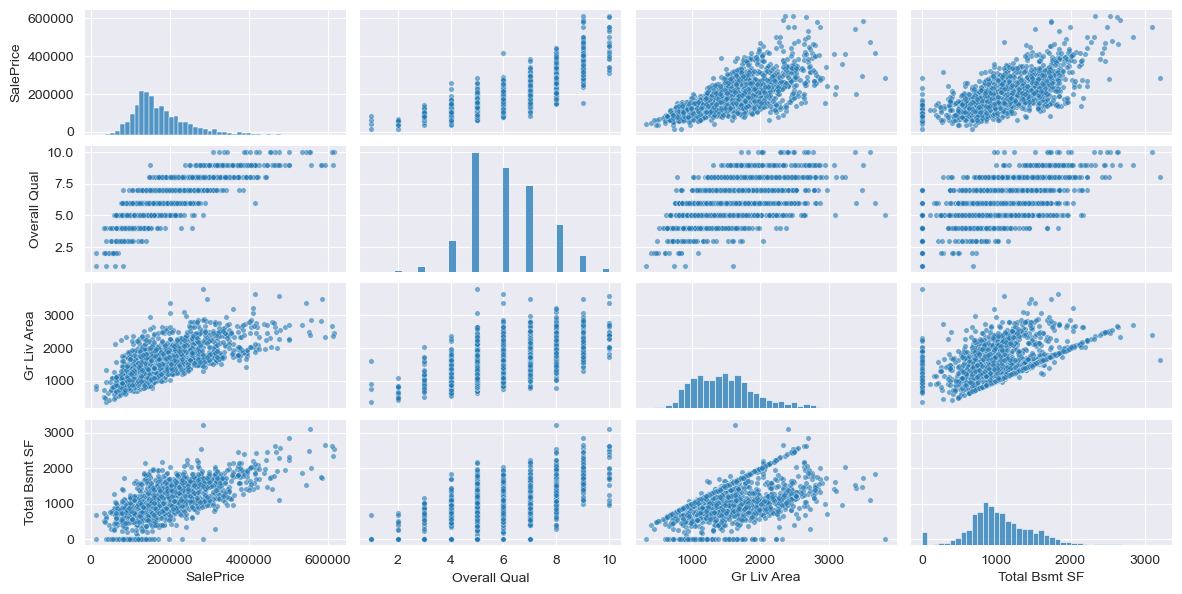

In [46]:
# Create pairplot with only top correlated columns
sns.pairplot(df[top_correlations], height=1.5, aspect=2, 
             plot_kws={'alpha': 0.6, 's': 15})
plt.show()

Base on pairplot, we chose to further investigate following combinations
* `SalePrice` vs `Overall Qual`
* `Gr Liv Area` vs `Overall Qual`
* `Total Bsmt SF` vs `Overall Qual`

We already saw previously also that $\sqrt SalePrice$ is a good candidate for z score outliers exclusion

##### SalePrice vs Overall Qual

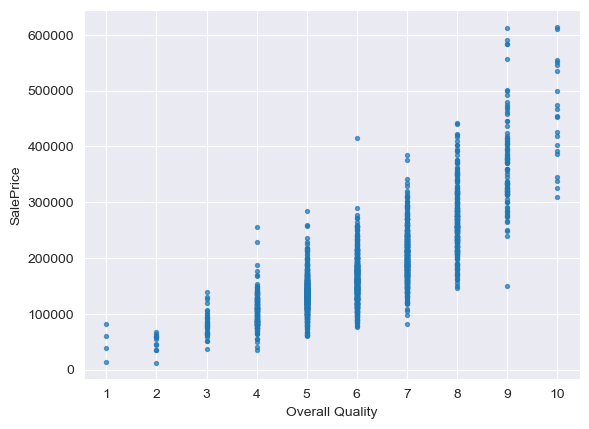

In [47]:
# Scatter plot Sale price versus Above grade (ground) living area square feet
y = df['SalePrice']
plt.scatter(df['Overall Qual'] , y, alpha=0.7, s=8)
plt.xlabel('Overall Quality')
plt.ylabel(y.name)

# Adding gridlines for every value of overall quality
plt.xticks(range(1, 11))
plt.show()

The values for each `Overall Qual` seems normally distributed. We will apply z scores to each value of Overall Quality.

In [48]:
def plot_hist_by_overall_qual(df, column,number_zscore):
    """
    Creates an histogram for each value of Overall Quality between 2 and 9
    Adds vertical lines for number_zscore zscores on each histogram
    """
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), 
                           tight_layout=True)

    axes = axes.ravel()

    # For every value of Overall Quality plot an histogram
    for i, quality in enumerate(range(2, 10)):
        # Extracting data for current Overall Quality
        data = df[df['Overall Qual'] == quality][column]
        
        axes[i].hist(data, bins=50, alpha=0.7)
        axes[i].set_title(f'Overall Quality = {quality}')
        axes[i].set_xlabel(column)

        # Adding vertical red lines for 2 z-scores
        mean = np.mean(data)
        std = np.std(data)
        axes[i].axvline(x=mean + number_zscore*std, color='red', alpha=0.3)
        axes[i].axvline(x=mean - number_zscore*std, color='red', alpha=0.3)

    plt.show()

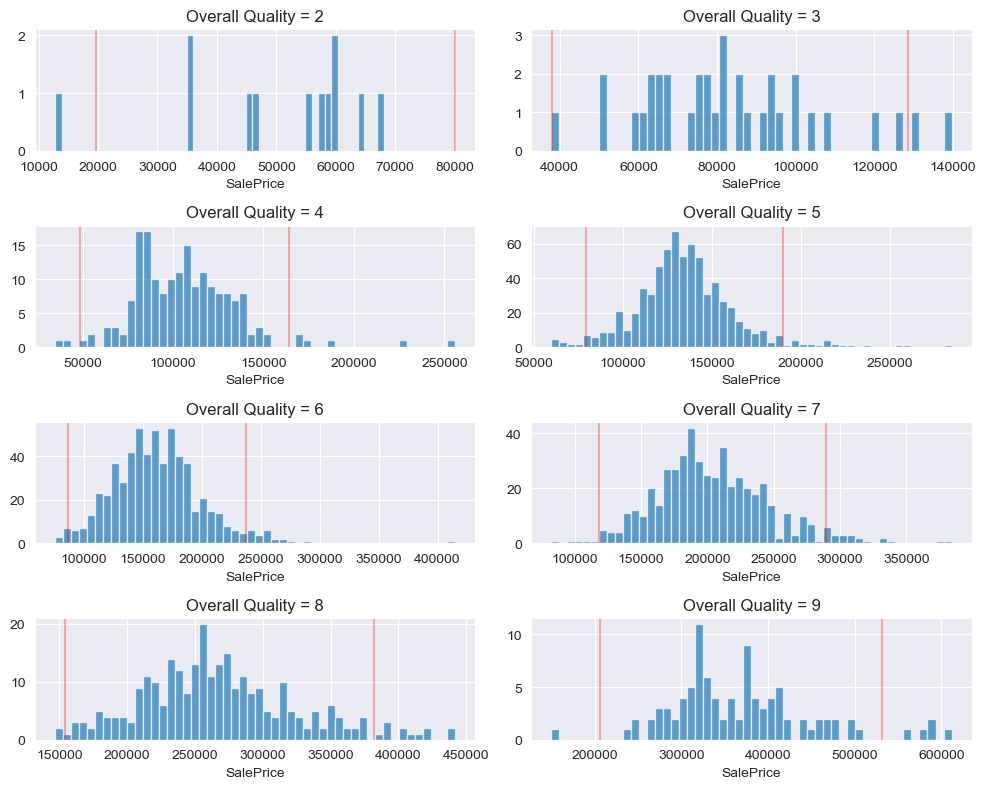

In [49]:
plot_hist_by_overall_qual(df,'SalePrice',2)

We initialize a column named 'outlier' to be able to flag and count outliers for each level of Overall Quality

In [50]:
df["outlier"] = 0

In [51]:
def mark_outliers(df, column, number_zscore):
    """
    Changes the value of column df['outlier'] to 1 if 
    values of given column are outside number_zscore zscores
    """

    # Looping through the range of Overall Quality
    for quality in range(2, 10):
        # Extracting data for current Overall Quality
        data = df[df['Overall Qual'] == quality][column]
        # Calculating mean and standard deviation
        mean = np.mean(data)
        std = np.std(data)
        # Identifying outliers
        outliers = df[(df['Overall Qual'] == quality) & 
                      ((df[column] < mean - number_zscore*std) | 
                       (df[column] > mean + number_zscore*std))]
        # Marking outliers
        df.loc[outliers.index, 'outlier'] = 1
        
    # Grouping by 'Overall Qual' and counting the number of outliers
    outliers_count = df.groupby(['Overall Qual'])['outlier'].sum()
    
    # Printing the count of outliers for each value of 'Overall Qual'
    print(outliers_count)

In [52]:
mark_outliers(df,'SalePrice',2)

Overall Qual
1      0
2      1
3      3
4      8
5     41
6     29
7     26
8     14
9      6
10     0
Name: outlier, dtype: int64


##### Gr Liv Area vs Overall Qual

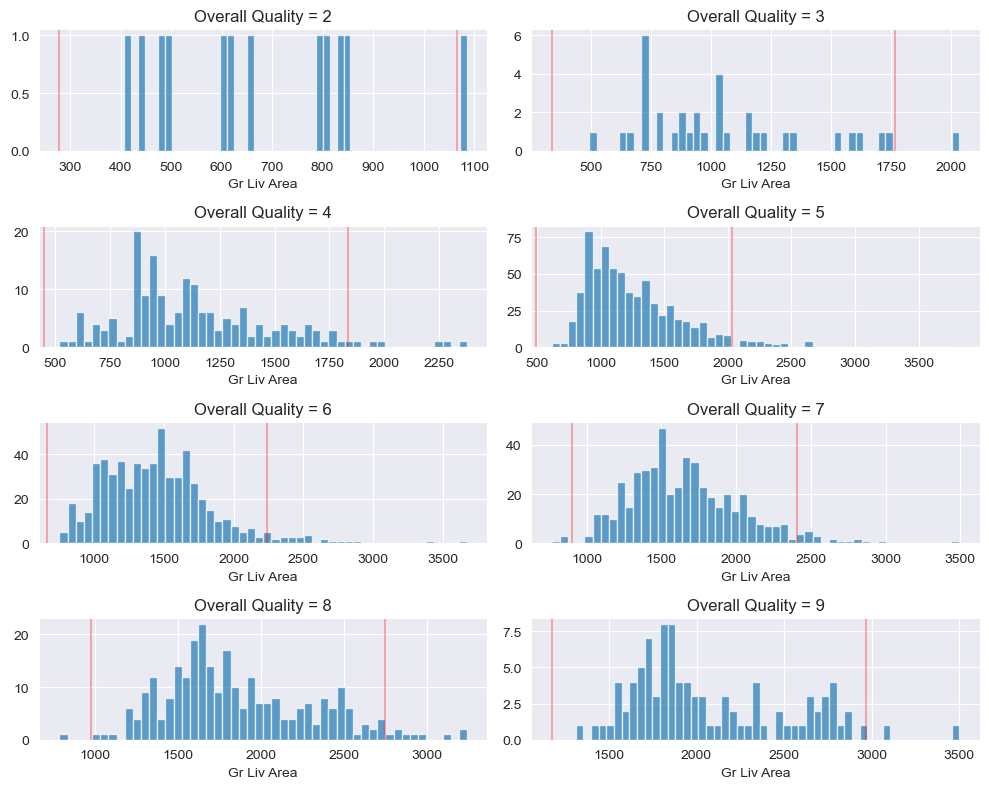

In [53]:
plot_hist_by_overall_qual(df,'Gr Liv Area',2)

In [54]:
mark_outliers(df,'Gr Liv Area',2)

Overall Qual
1      0
2      2
3      3
4     14
5     61
6     41
7     42
8     22
9      7
10     0
Name: outlier, dtype: int64


##### Total Bsmt SF vs Overall Qual

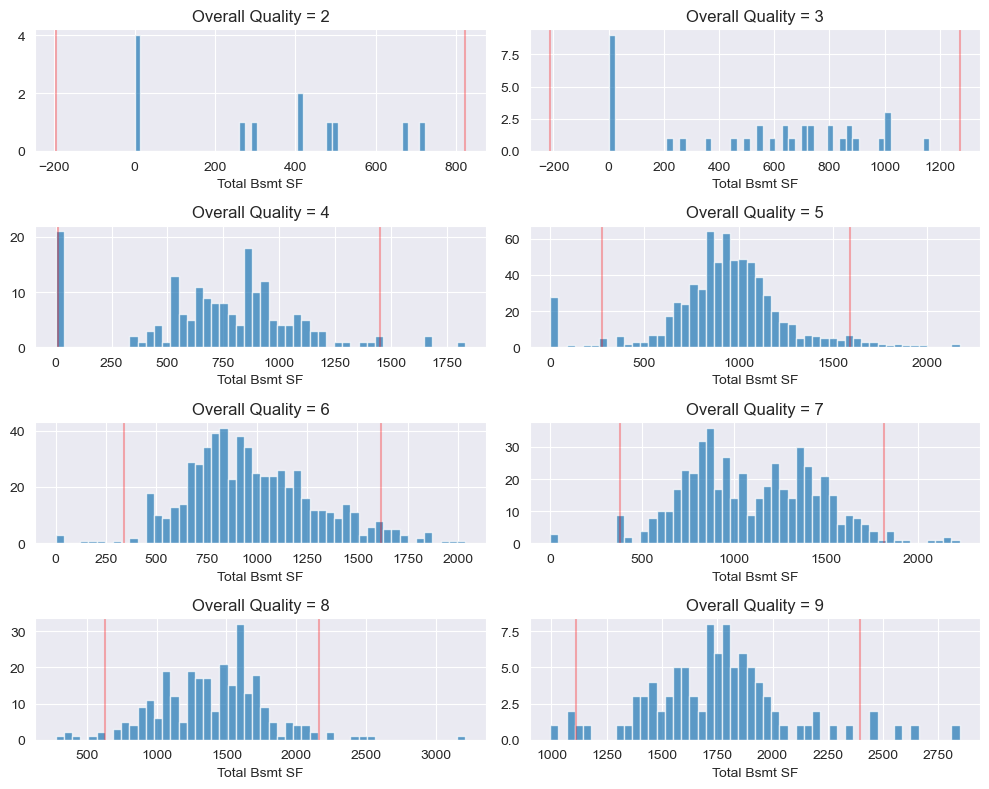

In [55]:
plot_hist_by_overall_qual(df,'Total Bsmt SF',2)

In [56]:
mark_outliers(df,'Total Bsmt SF',2)

Overall Qual
1       0
2       2
3       3
4      36
5     106
6      66
7      54
8      33
9      13
10      0
Name: outlier, dtype: int64


In [57]:
# Remove rows with outliers from the dataframe
df = df[df['outlier'] == 0]

##### Sqrt of SalePrice

Now we have seen that SalePrice is normally distributed so we will apply z score outliers exclusion to it 

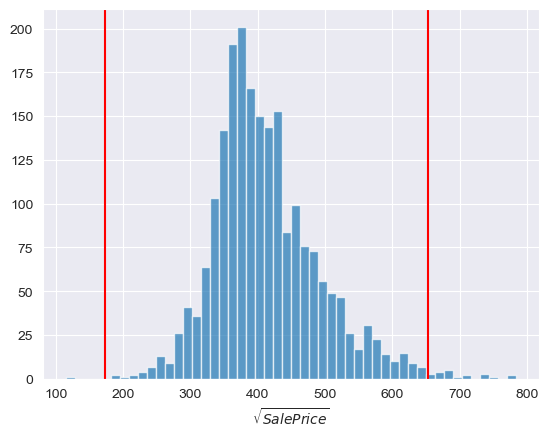

In [58]:
number_zscore = 3

# Calculate the square root of the SalePrice column
df['sqrt_SalePrice'] = np.sqrt(df['SalePrice'])

# Plot histogram of sqrt_sale_price
plt.hist(df['sqrt_SalePrice'], bins=50, alpha=0.7)
plt.xlabel("$\sqrt{SalePrice}$")

# Calculate z-scores for sqrt_sale_price
mean = np.mean(df['sqrt_SalePrice'])
std = np.std(df['sqrt_SalePrice'])
z_scores = (df['sqrt_SalePrice'] - mean) / std

# Add vertical red lines for z-scores above and below the mean
plt.axvline(mean + number_zscore * std, color='red')
plt.axvline(mean - number_zscore * std, color='red')

#Mark outliers in the data
df.loc[(z_scores > number_zscore) | (z_scores < -number_zscore), 'outlier'] = 1

plt.show()

In [59]:
# Count number of outliers for every level of 100,000 Sale Price
outlier_counts = {}
for i in range(10):
    lower_bound = i * 100_000
    upper_bound = (i + 1) * 100_000
    outlier_counts[f"{lower_bound} to {upper_bound}"] = sum((df['SalePrice'] > lower_bound) & (df['SalePrice'] <= upper_bound)
                                                            & (df['outlier'] == 1))
print(outlier_counts)

{'0 to 100000': 1, '100000 to 200000': 0, '200000 to 300000': 0, '300000 to 400000': 0, '400000 to 500000': 11, '500000 to 600000': 6, '600000 to 700000': 2, '700000 to 800000': 0, '800000 to 900000': 0, '900000 to 1000000': 0}


In [60]:
# Remove rows with outliers from the dataframe
df = df[df['outlier'] == 0]

We drop column 'outlier' as we are finished with outliers deletion.

In [61]:
df.drop('outlier', axis=1, inplace=True)

In [62]:
print('Dataset shape after cleaning:', df.shape,
      '\n kept', '{:.0%}'.format(df.shape[0] / initial_rows_count),'of rows and',
       '{:.0%}'.format(df.shape[1] / initial_columns_count),'of columns'
     )

Dataset shape after cleaning: (2093, 79) 
 kept 86% of rows and 96% of columns


# Feature encoding

## Ordinal features

We will manually re-encode each value from Ordinal features to a number based on documentation. The goal here is to not resort to OHE for all categorical variables as OHE does not keep ordinal relationship between independent and dependent. In this case, ordinal features indicate a degree of quality in property, and we can assume all things equal elsewhere the same property we better ordinal features would sell equally or for more money.

We also simplify ordinal features into less integers, as we can assume Quality notification are subjective and were not all made by the same observer. In most case it is not clear what difference exist between a Fair or Average ordinal feature. We can also say that for instance a good or excellent condition basement would be appraised equally as future home owners probably anyway make some adjustements once they settle in.

We treat ordinal features as we will investigate for ill conditioning and potential feature mutualization. Having feature as integer will help enable correlations study.

In [63]:
# Removing Overall Qual and Overall Cond as they are already ordered
ordinal_features_tomap = [col for col in ordinal_features if col not in ['Overall Qual', 'Overall Cond']]
# Create a dictionary to store ordinal feature column name, unique values, and mapped values
ordinal_dict = {}

# Iterate through ordinal feature columns in the dataframe
for column in df[ordinal_features_tomap]:
    # Get unique values in column and sort alphabetically
    unique_values = sorted(set(df[column].unique()).union(set(df_test[column].unique())))

    print(column , unique_values)
    # Add column name, unique values, and mapped values to dictionary
    ordinal_dict[column] = {"unique_values": unique_values, "remapped_unique_values": []}

Lot Shape ['IR1', 'IR2', 'IR3', 'Reg']
Utilities ['AllPub', 'NoSeWa', 'NoSewr']
Land Slope ['Gtl', 'Mod', 'Sev']
Exter Qual ['Ex', 'Fa', 'Gd', 'TA']
Exter Cond ['Ex', 'Fa', 'Gd', 'Po', 'TA']
Bsmt Qual ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
Bsmt Cond ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
Bsmt Exposure ['Absent', 'Av', 'Gd', 'Mn', 'No']
BsmtFin Type 1 ['ALQ', 'Absent', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf']
BsmtFin Type 2 ['ALQ', 'Absent', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf']
Heating QC ['Ex', 'Fa', 'Gd', 'Po', 'TA']
Electrical ['Absent', 'FuseA', 'FuseF', 'FuseP', 'SBrkr']
Kitchen Qual ['Ex', 'Fa', 'Gd', 'Po', 'TA']
Functional ['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sal', 'Typ']
Fireplace Qu ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
Garage Finish ['Absent', 'Fin', 'RFn', 'Unf']
Garage Qual ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
Garage Cond ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
Paved Drive ['N', 'P', 'Y']
Pool QC ['Absent', 'Fa', 'Gd', 'TA']


Now we will feed dictionnary manually with values.

* BsmtFin Type 1 ['ALQ', 'Absent', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf']
* BsmtFin Type 2 ['ALQ', 'Absent', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf']
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

We chose to group in three categories. The same logic will apply to all ordinal values, if the difference between qualities is not really clear, we will simplify classification.
['ALQ', 'Absent', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf'] > 
[2, 0, 1, 2, 0, 1, 0]

In [64]:
columns_to_remap =['BsmtFin Type 1', 'BsmtFin Type 2'] 
for key in columns_to_remap:
    ordinal_dict[key]["remapped_unique_values"] = [2, 0, 1, 2, 0, 1, 0]

* Fireplace Qu ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
* Garage Qual ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
* Garage Cond ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
* Bsmt Qual ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
* Bsmt Cond ['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']

We chose to group in three categories as we don't really see difference between Excellent and Good or Fair and Average
['Absent', 'Ex', 'Fa', 'Gd', 'Po', 'TA']
[0, 2, 1, 2, 0, 1]

In [65]:
columns_to_remap =['Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Bsmt Qual', 'Bsmt Cond'] 
for key in columns_to_remap:
    ordinal_dict[key]["remapped_unique_values"] = [0, 2, 1, 2, 0, 1]

* Kitchen Qual ['Ex', 'Fa', 'Gd', 'Po', 'TA']
* Heating QC ['Ex', 'Fa', 'Gd', 'Po', 'TA']
* Exter Cond ['Ex', 'Fa', 'Gd', 'Po', 'TA']

We chose to group in three categories as we don't really see difference between Excellent and Good or Fair and Average
[2, 1, 2, 0, 1]

In [66]:
columns_to_remap =['Kitchen Qual','Heating QC','Exter Cond'] 
for key in columns_to_remap:
    ordinal_dict[key]["remapped_unique_values"] = [2, 1, 2, 0, 1]

In [67]:
# Functional ['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sal', 'Typ']
ordinal_dict['Functional']["remapped_unique_values"] = [1, 1, 2, 2, 1, 0, 3]

# Electrical ['Absent', 'FuseA', 'FuseF', 'FuseP', 'SBrkr']
ordinal_dict['Electrical']["remapped_unique_values"] = [0, 1, 1, 0, 2]

# Utilities ['AllPub', 'NoSeWa', 'NoSewr']
ordinal_dict['Utilities']["remapped_unique_values"] = [2, 0, 1]

# Land Slope ['Gtl', 'Mod', 'Sev']
# Here we assign better score to no slope, as slope makes small humans fall
ordinal_dict['Land Slope']["remapped_unique_values"] = [2, 1, 0]

# Garage Finish ['Absent', 'Fin', 'RFn', 'Unf']
ordinal_dict['Garage Finish']["remapped_unique_values"] = [0, 2, 1, 0]

# Bsmt Exposure ['Absent', 'Av', 'Gd', 'Mn', 'No']
ordinal_dict['Bsmt Exposure']["remapped_unique_values"] = [0, 1, 2, 0, 0]

# Paved Drive ['N', 'P', 'Y']
ordinal_dict['Paved Drive']["remapped_unique_values"] = [0, 1, 2]

# Exter Qual ['Ex', 'Fa', 'Gd', 'TA']
ordinal_dict['Exter Qual']["remapped_unique_values"] = [2, 0, 1, 0]

# Pool QC ['Absent', 'Ex', 'Fa', 'Gd', 'TA']
ordinal_dict['Pool QC']["remapped_unique_values"] = [0, 2, 1, 2, 1]

# Lot Shape ['IR1', 'IR2', 'IR3', 'Reg']
# Here we guess that people prefer regular lots
ordinal_dict['Lot Shape']["remapped_unique_values"] = [2, 1, 0, 3]

We know apply dictionnary to both dataframes. We define a function for reusability

In [68]:
def remap_ordinal_values(df, ordinal_dict):
    """
    Remaps values in df based on ordinal_dict
    Returns modified dataframe
    """
    
    for column in ordinal_dict:
        # Check if the column name exists
        if column in df.columns:
            # Get unique values and remapped_unique_values for map
            unique_values = ordinal_dict[column]["unique_values"]
            remapped_values = ordinal_dict[column]["remapped_unique_values"]
            # Create a dictionary to use with map
            value_map = dict(zip(unique_values, remapped_values))
            # Remap the values in the column using map()
            df[column] = df[column].map(value_map)
    return df

Applying function to both dataframes, effectively converting all string ordinal features values to integer.

In [69]:
df = remap_ordinal_values(df,ordinal_dict)
df_test = remap_ordinal_values(df_test,ordinal_dict)

Sanity check on df_test, to check remapping as also been effective on df_test.

In [70]:
df_test[ordinal_features].apply(pd.Series.unique)

Lot Shape                         [2, 3, 1, 0]
Utilities                                  [2]
Land Slope                              [1, 2]
Overall Qual      [6, 5, 8, 4, 3, 7, 9, 10, 2]
Overall Cond          [7, 5, 3, 4, 6, 9, 8, 1]
Exter Qual                           [0, 1, 2]
Exter Cond                              [1, 2]
Bsmt Qual                            [1, 2, 0]
Bsmt Cond                            [1, 2, 0]
Bsmt Exposure                        [0, 1, 2]
BsmtFin Type 1                       [1, 2, 0]
BsmtFin Type 2                       [0, 1, 2]
Heating QC                           [1, 2, 0]
Electrical                           [2, 1, 0]
Kitchen Qual                            [1, 2]
Functional                        [3, 1, 2, 0]
Fireplace Qu                         [2, 0, 1]
Garage Finish                        [0, 1, 2]
Garage Qual                          [1, 0, 2]
Garage Cond                          [1, 0, 2]
Paved Drive                          [2, 0, 1]
Pool QC      

All good, all values have also been replaced on df_test.

## Nominal fatures
The nominal features are good candidates for one hot encoding as there is no relationship between levels of nominal and SaleValue. What we have to inspect is that if all Nominal Values are according to this logic, meaning the same way a t-shirt in S, M, L is should be the same price, if the nominal value has no intuitive link to price.

In [71]:
nominal_features

['MS SubClass',
 'MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Garage Type',
 'Sale Type',
 'Sale Condition']

### Neighborhood

When looking for a flat, the location of the flat is very important in determining the price of the flat.
We have no information on what constitutes a good neighborhood as we don't leave in Ames. We will test multiple numerical columns and see what features are best at explaining what neighborhood are similar, meaning we will look how cohesive are numerical feature for a given neighborhood.

This is the translation of in a good neighborhood, you will find similar quality of houses, the worst the neighborhood, the worst all housing are. Similary, one would expect a neighborhood with big houses with lot of frontage all in excellent quality to be the best neighborhood to live in.

In [72]:
explanation_columns = ['SalePrice','Year Built','Garage Yr Blt','Gr Liv Area','Total Bsmt SF','Lot Frontage','Overall Qual','Overall Cond','Garage Qual','Kitchen Qual','Heating QC', 'Exter Qual','Exter Cond','Bsmt Qual','Garage Cars','Garage Finish']

In [73]:
def group_agg_varcoef(df, categorical_column, *numerical_columns):
    """
    Creates a dataframe to see the var coefficient per value of the categorical column
    Goal is to see how well the categorical column is explained by numerical column 
    """
    df_grouped = df.groupby([categorical_column])[list(numerical_columns)].agg(['mean', 'std'])
    
    # Add a column for coefficient of variation
    for col in numerical_columns:
        df_grouped[col, 'var_coef'] = (df_grouped[col, 'std'] / df_grouped[col, 'mean']).round(2) 
    
    # Keep var_coef
    df_grouped = df_grouped.filter(like='var_coef') 
    
    # Following is used to return a dataframe showing most occurences first.
    # add a first column that is the count of records of categorical column    
    df_grouped.insert(0, "count", df[categorical_column].value_counts())
    
    # Order df_grouped descendingly based on count column
    df_grouped = df_grouped.sort_values(by='count', ascending=False) 
    return df_grouped

In [74]:
group_agg_varcoef(df, 'Neighborhood', *explanation_columns).head(10)

,count,SalePrice,Year Built,Garage Yr Blt,Gr Liv Area,Total Bsmt SF,Lot Frontage,Overall Qual,Overall Cond,Garage Qual,Kitchen Qual,Heating QC,Exter Qual,Exter Cond,Bsmt Qual,Garage Cars,Garage Finish
,,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef,var_coef
Neighborhood,,,,,,,,,,,,,,,,,
NAmes,318,0.19,0.00,0.01,0.25,0.24,0.25,0.14,0.18,0.15,0.33,0.34,4.32,0.30,0.26,0.39,1.19
CollgCr,221,0.25,0.01,0.00,0.27,0.28,0.23,0.16,0.12,0.15,0.24,0.17,0.67,0.24,0.15,0.25,0.68
OldTown,167,0.25,0.01,0.01,0.29,0.26,0.23,0.23,0.22,0.42,0.35,0.29,2.87,0.34,0.23,0.56,5.04
Somerst,141,0.23,0.00,0.00,0.17,0.33,0.35,0.12,0.03,0.00,0.11,0.00,0.31,0.00,0.04,0.20,0.68
Edwards,128,0.26,0.01,0.01,0.25,0.29,0.27,0.21,0.23,0.48,0.32,0.33,3.27,0.30,0.38,0.63,1.95
Gilbert,127,0.16,0.00,0.00,0.17,0.29,0.33,0.11,0.08,0.00,0.30,0.08,0.93,0.12,0.11,0.14,0.33
Sawyer,115,0.16,0.01,0.01,0.24,0.21,0.18,0.12,0.23,0.19,0.33,0.35,4.71,0.33,0.33,0.41,1.75
NridgHt,110,0.24,0.00,0.00,0.21,0.21,0.33,0.11,0.02,0.00,0.00,0.00,0.35,0.00,0.00,0.19,0.37


In [75]:
def dict_column_explanation_by_numerical_columns(df, categorical_column, *numerical_columns):
    """
    Returns a dictionnary ordered by lowest coefficient of variation in a numerical column
    by a categorical column
    Tries to look how good a categorical is explained by a numerical column, meaning how values are
    well or not aggregated when grouped by categorical column
    
    Low var_coeff means numerical is good at explaining categorical column
    """
    df_grouped = df.groupby([categorical_column])[list(numerical_columns)].agg(['mean', 'std'])
    
    # Add a column for coefficient of variation
    for col in numerical_columns:
        df_grouped[col, 'var_coef'] = (df_grouped[col, 'std'] / df_grouped[col, 'mean'])      
   
    # Add a count of records
    df_grouped.insert(0, "count", df[categorical_column].value_counts()) 

    var_coef_average = {}
    for col in numerical_columns:
        var_coef_average[col] = (df_grouped[col, 'var_coef'] * df_grouped['count']).sum() / df_grouped['count'].sum()
    
    # Sort by var_coef, lowest var_coef first
    var_coef_average = dict(sorted(var_coef_average.items(), key=lambda item: item[1]))

    # Format var_coef with only two decimals places 
    var_coef_average = {k: round(v, 2) for k, v in var_coef_average.items()}
    return print(var_coef_average)

In [76]:
dict_column_explanation_by_numerical_columns(df,'Neighborhood',*explanation_columns)

{'Year Built': 0.01, 'Garage Yr Blt': 0.01, 'Overall Qual': 0.15, 'Overall Cond': 0.16, 'Bsmt Qual': 0.21, 'Garage Qual': 0.21, 'SalePrice': 0.22, 'Heating QC': 0.23, 'Exter Cond': 0.23, 'Gr Liv Area': 0.24, 'Lot Frontage': 0.25, 'Total Bsmt SF': 0.26, 'Kitchen Qual': 0.27, 'Garage Cars': 0.36, 'Garage Finish': 1.42, 'Exter Qual': 2.15}


In [77]:
def calculate_property_rating(df, rating_column, numerical_cols):   
    for i, row in df.iterrows():        
        
        # Initialize a variable to store the sum of the ratios
        ratio_sum = 0
        
        # Iterate over each numerical column
        for col in numerical_cols:
            
            # Calculate the ratio of the row value to the mean of the column
            ratio = row[col] / df[col].mean()
            # Add the ratio to the ratio sum
            ratio_sum += ratio
       
        # update the rating_column value with ratio_sum
        df.at[i, rating_column] = ratio_sum
        
    return df

We see here `Year Built` and `Garage Yr Blt` are very cohesive for each neighborhood, meaning for each neighborhood the properties are dating back from same period. This is in indication we can drop both Year Built and Garage Yr Blt as they are basically translated already into `Neighborhood`

We select the first 6 numerical columns. After looking at how to chose to cluster / classify neigborhood based on those 6 numerical columns, i have not found a method i master yet since classification trees are in the following course. 

What we will do is to compare the value of a property versus the average value of all properties by numerical column. this should give us a number between in [0-1] then we average accross chosen numerical columns for a property. 

To calculate final score for each neighborhood, we chose trimmed mean from stats library, as i wanted a method less sensitive to outliers and still perform an aggregation (not taking median or mode).

In [78]:
neighborhood_rating_proxys = ['Overall Qual', 'Overall Cond', 'Bsmt Qual', 'Garage Qual', 'Heating QC', 'Exter Cond']
df['Neighborhood_rating'] = 0

df = calculate_property_rating(df,'Neighborhood_rating',neighborhood_rating_proxys)

Trimmed mean here calculates mean on 80% of the data (removes top 10% and bottom 10% with argument 0.1). https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trim_mean.html

In [79]:
df.groupby('Neighborhood')['Neighborhood_rating'].apply(lambda x: stats.trim_mean(x, 0.1)).sort_values()

Neighborhood
MeadowV    4.818182
IDOTRR     4.846154
BrDale     4.900000
SWISU      4.958333
Edwards    5.019231
Sawyer     5.021505
NAmes      5.031250
BrkSide    5.132353
OldTown    5.214815
NPkVill    5.235294
Mitchel    5.369231
NWAmes     5.387500
Blueste    5.666667
Crawfor    5.687500
SawyerW    5.788732
ClearCr    5.826087
CollgCr    5.960452
StoneBr    6.000000
Somerst    6.000000
Blmngtn    6.000000
Timber     6.000000
Landmrk    6.000000
Greens     6.000000
Gilbert    6.000000
NridgHt    6.000000
NoRidge    6.096774
Veenker    6.272727
Name: Neighborhood_rating, dtype: float64

Now we don't want to keep this a a float, we prefer to aggregate neighborhoods into five integers, as we believe this will be better for generalisation to testing data. Some Neighborhoods have only a few records.

In [80]:
neighborhood_rating_series = df.groupby('Neighborhood')['Neighborhood_rating'].apply(lambda x: stats.trim_mean(x, 0.1)).sort_values()

In [81]:
def create_bucket_mapping(series, n):
    '''
    Based on the size of series, divide series into n bucket
    '''
    # Create a dictionary to store the mapping
    mapping = {}
    # Get the size of the series
    size = len(series)
    # Calculate the size of each bucket
    bucket_size = size/n
    bucket_index = 0
    # Iterate through the series values
    for i, value in enumerate(series):
        # check if the current index is greater or equal than the size of the bucket
        if i>= (bucket_index+1)*bucket_size:
            bucket_index += 1
        # Map the index of the current value to the corresponding bucket
        mapping[series.index[i]] = bucket_index
    return mapping


In [82]:
neighborhood_dict = create_bucket_mapping(neighborhood_rating_series,5)
neighborhood_dict

{'MeadowV': 0,
 'IDOTRR': 0,
 'BrDale': 0,
 'SWISU': 0,
 'Edwards': 0,
 'Sawyer': 0,
 'NAmes': 1,
 'BrkSide': 1,
 'OldTown': 1,
 'NPkVill': 1,
 'Mitchel': 1,
 'NWAmes': 2,
 'Blueste': 2,
 'Crawfor': 2,
 'SawyerW': 2,
 'ClearCr': 2,
 'CollgCr': 2,
 'StoneBr': 3,
 'Somerst': 3,
 'Blmngtn': 3,
 'Timber': 3,
 'Landmrk': 3,
 'Greens': 4,
 'Gilbert': 4,
 'NridgHt': 4,
 'NoRidge': 4,
 'Veenker': 4}

We now apply this dictionnary to remap float neighborhood_ratin column into 5 integer values using dictionnary

In [83]:
df['Neighborhood_rating'] = df['Neighborhood'].map(neighborhood_dict)
df_test['Neighborhood_rating'] = df_test['Neighborhood'].map(neighborhood_dict)

Scatterplot with hue on Neighborhood_rating (as integer)

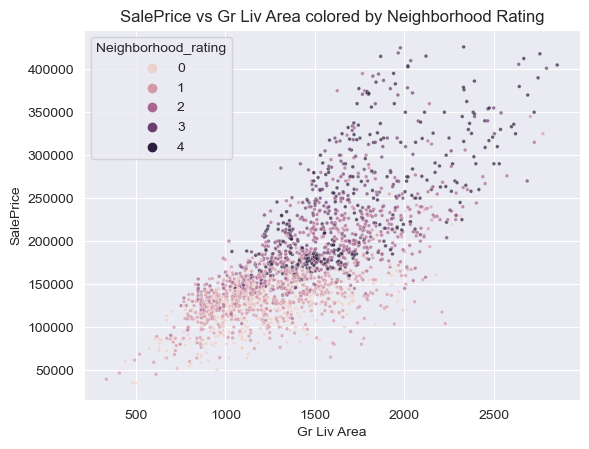

In [84]:
sns.scatterplot(x='Gr Liv Area',
                y='SalePrice',
                hue='Neighborhood_rating',
                alpha=0.7,
                data=df,
                s=7)
plt.title('SalePrice vs Gr Liv Area colored by Neighborhood Rating')
plt.show()

I think this chart shows that the 5 categories well separate into 5 gradients on the chart, on the overlapping looks also satisfying as it is possible in a city to have the a 40 sqt flat property in a very good neighborhood, cost as much as a 100 sqt flat in a bad neighborhood.

Removing Neighborhood as it is now translated under ordinal feature Neighborhood_rating

In [86]:
nominal_features.remove('Neighborhood')

### Sale Condition

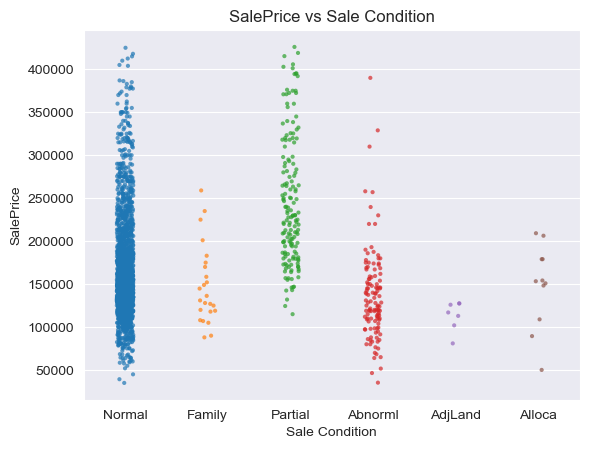

In [85]:
sns.stripplot(x='Sale Condition',
              y='SalePrice',
              data=df,
              alpha=0.7,
              s=3)
plt.title('SalePrice vs Sale Condition')
plt.show()

As indicated in documentation, the `Sale Condition` affects `SalePrice`.

I choose not to encoding it as an ordinal variable because looking at scatter plot, I can not order easily classes between them, even if it is clear that one would sell lower to one's family, but there is outliers in Normal Sales, and there is not the same amount of samples in AdjLand and Alloca, so it is hard to order. `Sale Condition` is a great candidate for OHE encoding.

### Other Nominal features

We reuse the methodology applied on Neigborhood to see if we can explain other nominal values using numerical columns.

In [87]:
df[nominal_features].apply(pd.Series.unique)

MS SubClass       [60, 160, 20, 190, 50, 70, 120, 30, 90, 85, 45...
MS Zoning               [RL, RM, FV, I (all), RH, C (all), A (agr)]
Street                                                 [Pave, Grvl]
Land Contour                                   [Lvl, Bnk, HLS, Low]
Lot Config                      [Inside, Corner, CulDSac, FR2, FR3]
Condition 1       [Norm, Feedr, PosN, RRAe, Artery, PosA, RRAn, ...
Condition 2                 [Norm, PosA, Feedr, Artery, RRNn, PosN]
Bldg Type                     [1Fam, Twnhs, 2fmCon, TwnhsE, Duplex]
House Style       [2Story, 1Story, 2.5Unf, 1.5Fin, SFoyer, 1.5Un...
Roof Style               [Gable, Hip, Flat, Gambrel, Mansard, Shed]
Roof Matl         [CompShg, Tar&Grv, WdShake, Metal, WdShngl, Me...
Exterior 1st      [VinylSd, CemntBd, BrkFace, Wd Sdng, MetalSd, ...
Exterior 2nd      [VinylSd, CmentBd, BrkFace, Wd Sdng, MetalSd, ...
Mas Vnr Type                 [None, BrkFace, Stone, BrkCmn, CBlock]
Foundation               [PConc, CBlock, BrkTil,

In [88]:
dict_column_explanation_by_numerical_columns(df,'MS Zoning',*explanation_columns)

{'Garage Yr Blt': 0.01, 'Year Built': 0.01, 'Overall Cond': 0.18, 'Overall Qual': 0.21, 'Garage Qual': 0.24, 'Exter Cond': 0.27, 'Heating QC': 0.27, 'Gr Liv Area': 0.28, 'Lot Frontage': 0.29, 'Total Bsmt SF': 0.32, 'Bsmt Qual': 0.32, 'Kitchen Qual': 0.33, 'SalePrice': 0.34, 'Garage Cars': 0.41, 'Garage Finish': 1.16, 'Exter Qual': 1.47}


* `MS Zoning`: Identifies the general zoning classification of the sale. Example values: Residential High Density, Residential Low Density, Residential Low Density Park. 
This does not as easily translates intuitively as `Neighborhood into an indication of the SalePrice. You can have low priced low density properties and highly priced High Densitiy and vice versa. `SalePrice` standard deviation is 38% of the mean.

In [89]:
dict_column_explanation_by_numerical_columns(df,'MS SubClass',*explanation_columns)

{'Year Built': 0.01, 'Garage Yr Blt': 0.01, 'Overall Cond': 0.17, 'Overall Qual': 0.19, 'Gr Liv Area': 0.22, 'Garage Qual': 0.22, 'Lot Frontage': 0.25, 'Exter Cond': 0.26, 'Heating QC': 0.26, 'Total Bsmt SF': 0.27, 'Bsmt Qual': 0.27, 'SalePrice': 0.3, 'Kitchen Qual': 0.31, 'Garage Cars': 0.39, 'Garage Finish': 1.51, 'Exter Qual': 1.67}


Similar conclusion on `MS Class` that identifies type of property, example values DUPLEX - ALL STYLES AND AGES or 1-STORY 1946 & NEWER ALL STYLES.

In [90]:
dict_column_explanation_by_numerical_columns(df,'Condition 1',*explanation_columns)

{'Garage Yr Blt': 0.01, 'Year Built': 0.01, 'Overall Cond': 0.19, 'Overall Qual': 0.22, 'Garage Qual': 0.25, 'Exter Cond': 0.27, 'Heating QC': 0.27, 'Gr Liv Area': 0.28, 'Lot Frontage': 0.3, 'Bsmt Qual': 0.33, 'Total Bsmt SF': 0.33, 'Kitchen Qual': 0.34, 'SalePrice': 0.36, 'Garage Cars': 0.42, 'Garage Finish': 1.11, 'Exter Qual': 1.42}


Similar conclusion on `Condition 1` that identifies proximity to various conditions, such as close to a main street or a train station.

In [91]:
dict_column_explanation_by_numerical_columns(df,'Bldg Type',*explanation_columns)

{'Garage Yr Blt': 0.01, 'Year Built': 0.01, 'Overall Cond': 0.19, 'Overall Qual': 0.22, 'Garage Qual': 0.25, 'Lot Frontage': 0.27, 'Heating QC': 0.27, 'Exter Cond': 0.27, 'Gr Liv Area': 0.28, 'Total Bsmt SF': 0.33, 'Bsmt Qual': 0.33, 'Kitchen Qual': 0.33, 'SalePrice': 0.36, 'Garage Cars': 0.42, 'Garage Finish': 1.13, 'Exter Qual': 1.41}


Similar conclusion on `Bldg Type` that identifies type of dweeling example values: Single-family Detached	or Duplex

In [92]:
dict_column_explanation_by_numerical_columns(df,'Central Air',*explanation_columns)

{'Garage Yr Blt': 0.01, 'Year Built': 0.01, 'Overall Cond': 0.19, 'Overall Qual': 0.22, 'Garage Qual': 0.25, 'Heating QC': 0.27, 'Exter Cond': 0.28, 'Gr Liv Area': 0.28, 'Lot Frontage': 0.3, 'Total Bsmt SF': 0.33, 'Bsmt Qual': 0.33, 'Kitchen Qual': 0.33, 'SalePrice': 0.36, 'Garage Cars': 0.42, 'Garage Finish': 1.3, 'Exter Qual': 1.53}


`Central Air` presence or not which would have been intuitively a good candidate for conversion to integer, as one can assume it is better to have central air than not. But `SalePrice` is not cohesive enough around `Central Air` so maybe Ames is not so hot of a town (looking at google month of July and August are only 2-3 hotter than Geneva in average, and `Central Air` in Geneva is scarce for personal housing).

## Time of sale

We are going to try and convert the month and year sold to a new column that will match a time period for a bullish or bearish housing market. We take into account only normal sales to try and make a trend out of saleprice as family sales for instance will not follow trend.

In [93]:
# Transform 'Mo Sold' and 'Yr Sold' columns to a datetime
df['Month_year'] = df.apply(lambda x: pd.to_datetime(str(x['Yr Sold']) + '-' + str(x['Mo Sold']) + '-1'), axis=1)
df_test['Month_year'] = df.apply(lambda x: pd.to_datetime(str(x['Yr Sold']) + '-' + str(x['Mo Sold']) + '-1'), axis=1)

# Resample dataframe by averaging 'SalePrice' for each 'Month_year'
df_avgMonthlyPrices = df[df['Sale Condition']=='Normal'].resample('M', on='Month_year').mean()

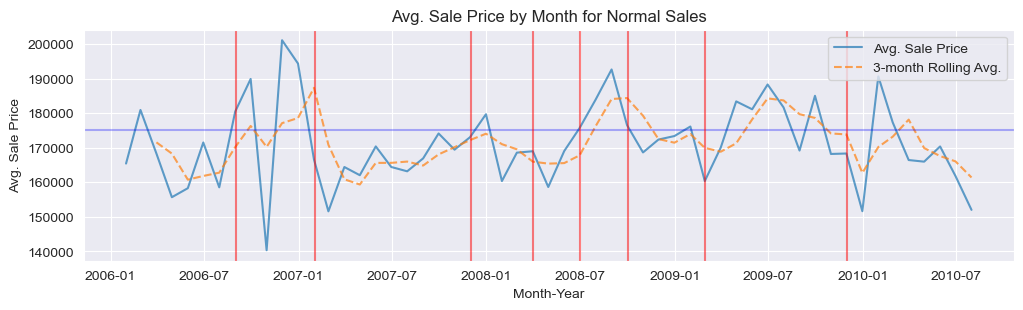

In [94]:
plt.figure(figsize=(12,3))

# Plot df['Sale Condition']=='Normal' sales prices 
x = df_avgMonthlyPrices.index

# Compute rolling average over 3 months for 'SalePrice'
y_3m_rolling_avg = df_avgMonthlyPrices['SalePrice'].rolling(window=3).mean()

plt.plot(x, df_avgMonthlyPrices['SalePrice'], label='Avg. Sale Price', alpha=0.7)
plt.plot(x, y_3m_rolling_avg, label='3-month Rolling Avg.', alpha=0.7, linestyle='dashed')

plt.title('Avg. Sale Price by Month for Normal Sales')
plt.xlabel('Month-Year')
plt.ylabel('Avg. Sale Price')
plt.legend()

# Here we plotted arbitrary lines incrementaly 
# goal is to segment across time by market behavior
plt.axhline(y=175000, color='b', alpha = 0.3)

# Adding vertical lines that segment overtime
plt.axvline(x=pd.to_datetime("2006-09-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2007-02-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2007-12-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2008-04-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2008-07-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2008-10-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2009-03-01"), color='red', alpha = 0.5)
plt.axvline(x=pd.to_datetime("2009-12-01"), color='red', alpha = 0.5)

plt.show()

Based on this we are going to create a new dataframe column in train and test datasets, that maps out the Month Year to a integer based on the different intervals we described in the chart. This will convert both 'Mo Sold' and 'Yr Sold' to a column with values ranging from 1 to 9

In [95]:
# Adding minimum and maximum in 2000 and 2020
price_shifts_timebounds = [pd.to_datetime('2000-01-01'),pd.to_datetime('2006-09-01'),pd.to_datetime('2007-02-01'),pd.to_datetime('2007-12-01'),
                           pd.to_datetime('2008-04-01'),pd.to_datetime('2008-07-01'),pd.to_datetime('2008-10-01'),
                           pd.to_datetime('2009-03-01'),pd.to_datetime('2009-12-01'),pd.to_datetime('2020-01-01')]

df['Time_period'] = 1
df_test['Time_period'] = 1

In [96]:
# Iterate over the list of price shifts time bounds
for i in range(len(price_shifts_timebounds)-1):
    lower_bound = price_shifts_timebounds[i]
    upper_bound = price_shifts_timebounds[i+1]
    
    in_timebound_df = (df['Month_year'] > lower_bound) & (df['Month_year'] <= upper_bound)
    df.loc[in_timebound_df, 'Time_period'] = i+1
    
    in_timebound_dftest = (df_test['Month_year'] > lower_bound) & (df_test['Month_year'] <= upper_bound)
    df_test.loc[in_timebound_dftest, 'Time_period'] = i+1

In [97]:
print(df.SalePrice.groupby(df['Time_period']).mean())

Time_period
1    171253.088154
2    170162.651786
3    174589.219828
4    167585.601695
5    177344.680000
6    185194.768293
7    172337.928571
8    179715.217848
9    169179.004000
Name: SalePrice, dtype: float64


This column will be a good candidate for one hot encoding as we see difference of mean around 5-10K USD between time periods (but there is no ordinality in column).

## Investigating potential Ill-conditioning

We investigate potential ill-conditioning on similar features (exemple all features describing a basement) to identify potentials for feature mutualization. We have too many features at this point for correlation matrix to be easily readable, so we go with listing top correlated features. We use itertools to iterate over all combinations of two columns in a dataframe and get correlations as a results https://stackoverflow.com/a/66805463

In [98]:
def find_highest_correlated_columns(df,number_top_correlations):
    """
    Compute correlations from pairs of numerical columns from a dataframe df
    Returns the top number_top_correlations as a list
    Use to investigate ill-conditionning 
    """
    highest_correlated_columns = []
    
    # Iterating over all possible column pairs
    for col1, col2 in itertools.combinations(df.columns, 2):
        # Correlation between pair
        corr = df[col1].corr(df[col2])
        # Add to list
        highest_correlated_columns.append((col1, col2, round(corr,3)))
        # Sorting list by top correlations
        highest_correlated_columns.sort(key=lambda x: x[2], reverse=True)
    
    return highest_correlated_columns[:number_top_correlations]

Here we take out of highest correlated columns the `Sale Price` and `sqrt_SalePrice`, as we want to investigate correlations between independent columns. 
* We also take out `Year Built` and `Garage Yr Blt` as they were highly cohesive to neighborhood which we replaced by neighborhood rating. 
* `Yr Sold` and `Mo Sold`, we also remove as we replaced them by `Time_period`

In [99]:
dropped_for_analysis = ['SalePrice','sqrt_SalePrice','Year Built','Garage Yr Blt','Yr Sold','Mo Sold','Lot Frontage','Lot Area']
find_highest_correlated_columns(df.drop(dropped_for_analysis,axis=1).select_dtypes(include='number'),25)

[('Pool Area', 'Pool QC', 0.931),
 ('Garage Qual', 'Garage Cond', 0.899),
 ('Garage Cars', 'Garage Area', 0.889),
 ('Total Bsmt SF', '1st Flr SF', 0.882),
 ('Fireplaces', 'Fireplace Qu', 0.808),
 ('Gr Liv Area', 'TotRms AbvGrd', 0.783),
 ('BsmtFin Type 2', 'BsmtFin SF 2', 0.778),
 ('Overall Qual', 'Exter Qual', 0.719),
 ('log_LotFrontage', 'log_LotArea', 0.71),
 ('BsmtFin Type 1', 'BsmtFin SF 1', 0.689),
 ('Exter Qual', 'Kitchen Qual', 0.687),
 ('Overall Qual', 'Neighborhood_rating', 0.664),
 ('2nd Flr SF', 'Gr Liv Area', 0.657),
 ('Bedroom AbvGr', 'TotRms AbvGrd', 0.649),
 ('Year Remod/Add', 'Kitchen Qual', 0.644),
 ('Bsmt Qual', 'Neighborhood_rating', 0.643),
 ('2nd Flr SF', 'Half Bath', 0.64),
 ('Exter Qual', 'Neighborhood_rating', 0.636),
 ('Overall Qual', 'Gr Liv Area', 0.632),
 ('Overall Qual', 'Bsmt Qual', 0.628),
 ('BsmtFin SF 1', 'Bsmt Full Bath', 0.626),
 ('Overall Qual', 'Kitchen Qual', 0.62),
 ('Gr Liv Area', 'Full Bath', 0.614),
 ('Overall Qual', 'Garage Cars', 0.608),
 ('

Looking at top correlations, these are candidates we identify for mutualization :
* ('Garage Cars', 'Garage Area', 0.889)
* ('Garage Qual', 'Garage Cond', 0.889)
* ('Pool Area', 'Pool QC', 0.831),
* ('Fireplaces', 'Fireplace Qu', 0.808)

For simple and average complex linear model (not sure at this stage about which features to select), we also get from this investigation idea to
* Mutualize square footage indicator into creating a 'Total SF' = `Total Bsmt SF` + `Gr Liv Area` and to not include other SF metrics such as `1st Flr SF` or `2nd Flr SF` or `BsmtFin SF 2`. For the complex model we will drop the sum column as it would imply high colinearity between sum and sum components.
* Aggregate Quality metrics into one. It is intuitive that an house in good condition tends to have various components in good condition. We keep only quality features mandatory in property, meaning an overall, external and kitchen quality (a garage or a basement can be absent)

Now we want to aggregate numerical features that don't share same scale. The https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/gradient-descent-v4/units/note-about-feature-scaling-v4 presents the min max scaling which seems to be a good candidate as after standardizing each feature our intent is to sum them or taking the mean of them (which in the end as same sensitive to outliers either in sum or taking mean of two features). So knowing that standardized feature will stay between 0 and 1 will help. 

However, we have to be careful about test set contamination, so we will fit a minmax scaler onto training data and rescale features in df_test with this scaler before summing them both in train and test_data.

In [100]:
from sklearn.preprocessing import MinMaxScaler

In [101]:
def features_aggregation_using_minmax(df_train, df_test, features, rescaled_feature):
    """
    Takes as input a training and test dataframe
    Applies minmax scaling and fit the MinMaxScaler on each feature of training dataframe
    Applies the minmax transformation to the test dataframe
    
    Then in a new column called 'rescaled feature' in test and training dataframe
    sums all rescaled feature into one
    
    Finally it drops new rescaled columns created for calculation
    """
    for feature in features:
        # Initialize the MinMaxScaler()
        scaler = MinMaxScaler()
        
        # Fit and transform the scaler on the training data
        df_train[f"minmaxed_{feature}"] = scaler.fit_transform(df_train[[feature]])
        
        # Apply the transformation to the test data
        df_test[f"minmaxed_{feature}"] = scaler.transform(df_test[[feature]])
    
    # Sum the transformed feature columns in the training data and store in new column
    df_train[rescaled_feature] = df_train[[f"minmaxed_{feature}" for feature in features]].sum(axis=1)
    
    # Do the same on test dataframe
    df_test[rescaled_feature] = df_test[[f"minmaxed_{feature}" for feature in features]].sum(axis=1)
    
    # Drop the transformed feature columns
    df_train.drop(columns=[f"minmaxed_{feature}" for feature in features], inplace=True)
    df_test.drop(columns=[f"minmaxed_{feature}" for feature in features], inplace=True)

We start by aggregating quality_features for quality_features found in every property.

In [102]:
quality_features = ['Overall Qual','Exter Qual','Kitchen Qual']

In [103]:
features_aggregation_using_minmax(df,df_test,quality_features,'Quality_aggregated')

We now perform the same transformation on other identified pairs

In [104]:
garage_aggregators = ['Garage Cars', 'Garage Area', 'Garage Cond']
pool_aggregators = ['Pool Area', 'Pool QC']
fireplace_aggregators = ['Fireplaces', 'Fireplace Qu']

In [105]:
features_aggregation_using_minmax(df,df_test,garage_aggregators,'Garage_aggregated')

In [106]:
features_aggregation_using_minmax(df,df_test,pool_aggregators,'Pool_aggregated')

In [107]:
features_aggregation_using_minmax(df,df_test,fireplace_aggregators,'Fireplace_aggregated')

## Total_SF

We define a Total_SF that is the sum of above ground and below ground square feet, or could also be named 'actual_perceived_SF'. This is hinted in the pdf documentation of the exercice. We will make sure not to include both the sum and its components in our models further down.

In [108]:
df['Total SF'] = df['Gr Liv Area'] + df['Total Bsmt SF']
df_test['Total SF'] = df_test['Gr Liv Area'] + df_test['Total Bsmt SF']

## Cleaning no longer used features

Before moving on, we will inspect and clean our dataframe. We clean highly correlated numerical features and features used to transform.

In [109]:
features_to_drop = ['Year Built','Garage Yr Blt',
                    'Yr Sold','Mo Sold','Month_year',
                    'Garage Cars', 'Garage Area', 'Garage Cond',
                    'Pool Area', 'Pool QC',
                    'Fireplaces', 'Fireplace Qu',
                    'Lot Frontage', 'Lot Area',
                    'Neighborhood']

In [110]:
# Drop SalePrice from training dataframe as our dependent variable is now sqrt_SalePrice
df.drop('SalePrice', axis=1, inplace=True)

In [111]:
# Remove features from dataframes
df.drop(features_to_drop, axis=1, inplace=True)
df_test.drop(features_to_drop, axis=1, inplace=True)

# Remove entry from features_dict when key is an element of list 'features_to_drop'
features_dict = {k: v for k, v in features_dict.items() if k not in features_to_drop}

## Candidates for polynomial transformation

We take the time to identify if some variables have a visual non linear relationship to target variable. We inspect particularly for sine wave or parabola which both indicate candidates for polynomial transformations.

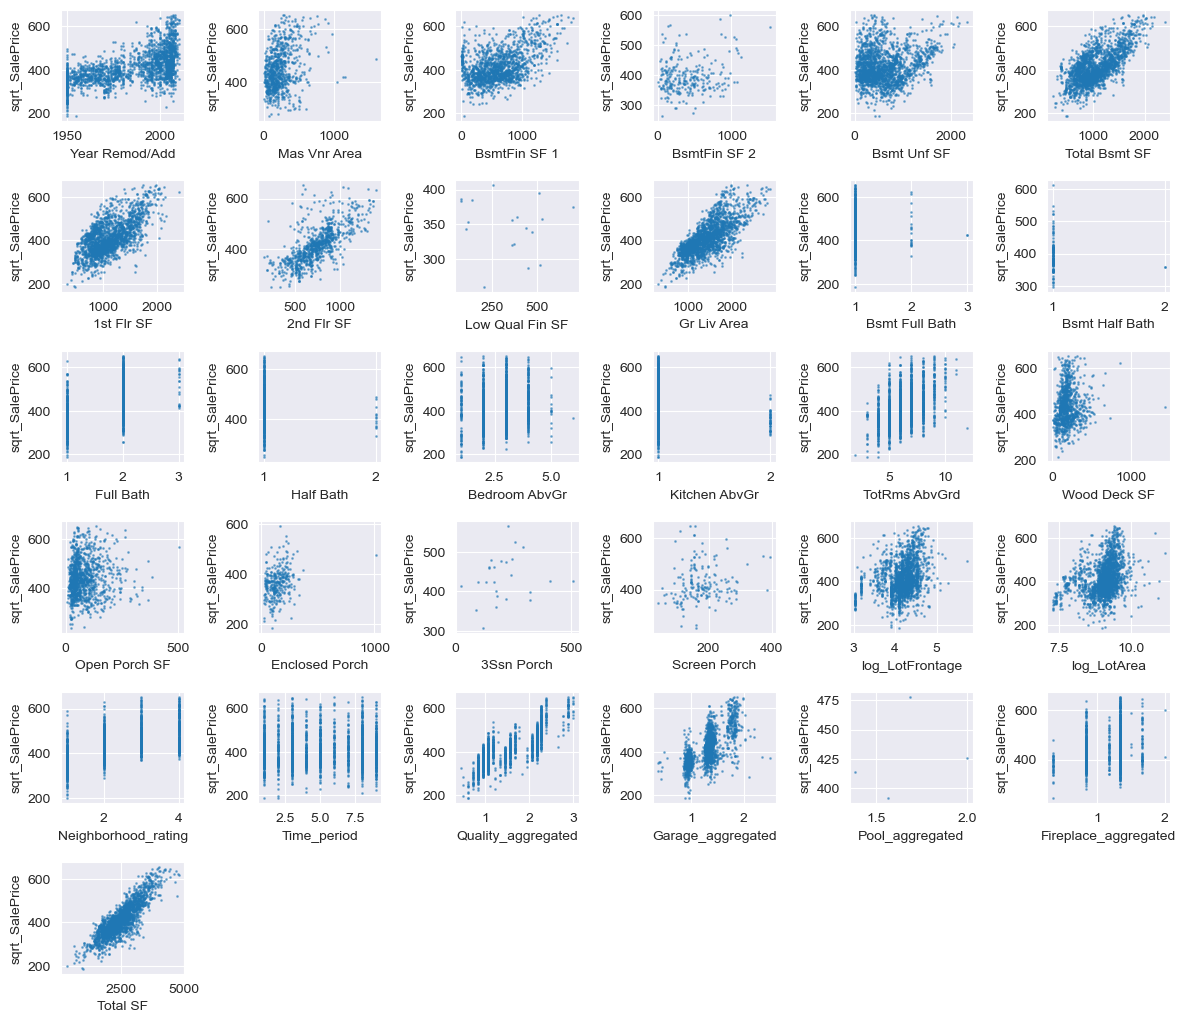

In [112]:
dropped_for_analysis = ['sqrt_SalePrice','MS SubClass']
features = df.drop(dropped_for_analysis,axis=1).select_dtypes(include='number')

# We remove ordinal features as they are discrete
features = df[[feature for feature in features if feature not in ordinal_features]]

TOTAL_WIDTH = 6               
# Calculate the number of rows needed to fit all the charts
total_height = features.shape[1] // TOTAL_WIDTH
figure_height = features.shape[1] / TOTAL_WIDTH * 2

# Check if there are any extra columns that don't fit evenly into a full row
if features.shape[1] % TOTAL_WIDTH != 0:
# If there are extra columns, we need an additional row
    total_height += 1

fig, axes = plt.subplots(total_height,TOTAL_WIDTH,
                         figsize=(2*TOTAL_WIDTH,figure_height))
axes = axes.ravel()

# Loop through features
for i, feature in enumerate(features):
    # Scatter plot of feature vs sqrt_SalePrice
    axes[i].scatter(df[df[feature]>0][feature], df[df[feature]>0]['sqrt_SalePrice'], alpha=0.5, s=1)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('sqrt_SalePrice')

plt.tight_layout()

for ax in axes.flatten():
    if not ax.has_data():
        ax.remove()

plt.show()

This do not exhibit any parabola nor sine wave, so we chose not to go for polynomial feature engineering

## Creating Dummies with nominal features

In [113]:
df.select_dtypes(exclude='number').head()

,MS Zoning,Street,Land Contour,Lot Config,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Sale Type,Sale Condition
0,RL,Pave,Lvl,Inside,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,BuiltIn,WD,Normal
2,RM,Pave,Lvl,Inside,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,CBlock,GasA,Y,Attchd,WD,Normal
3,RL,Pave,Lvl,Inside,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,CBlock,GasA,Y,Attchd,WD,Normal
4,RM,Pave,Bnk,Inside,Feedr,Norm,2fmCon,2.5Unf,Hip,CompShg,Wd Sdng,Wd Sdng,None,CBlock,GasA,N,Detchd,WD,Normal
5,RL,Pave,Lvl,Corner,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,Detchd,WD,Normal


In [114]:
df = pd.get_dummies(df, dummy_na=False)
df_test = pd.get_dummies(df_test, dummy_na=False)

We know have to make sure columns are the same in both dataframe 

In [115]:
def compare_dataframes(df, df_test, dependent_variable):
    '''
    Compares columns from two dataframes, exclude dependent_variable from df 
    adds missing columns in both df and reorder columns to same order 
    '''
    # Exclude dependent variable from df columns
    df_cols = [col for col in df.columns.tolist() if col != dependent_variable]
    df_test_cols = df_test.columns.tolist()
    
    # Find missing columns in each dataframe
    cols_missing_in_df = [col for col in df_test_cols if col not in df_cols]
    cols_missing_in_df_test = [col for col in df_cols if col not in df_test_cols]
    
    # Add missing columns to dataframe where they are missing
    for col in cols_missing_in_df:
        df[col] = 0
    for col in cols_missing_in_df_test:
        df_test[col] = 0

In [116]:
compare_dataframes(df,df_test,'sqrt_SalePrice')

In [117]:
# Reorder columns in both dataframes to match each other
df_test_cols = df_test.columns.tolist()
df_cols = df_test_cols + ['sqrt_SalePrice']
df = df[df_cols]

Now comparing missing columns present in df_test and not in df

# Simple, intermediate models

## Choosing variables

We decide to test the SelectKBest object that we found in Scikit-learn to do automatic feature selection (it is suggested in course). We use f_regression as score_function as it is recommended for regressions https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

In [118]:
# Importing required library
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [119]:
num_features = 40

# Initializing feature selector
selector = SelectKBest(f_regression, k=num_features)

# Splitting data into independent and dependent variables
X = df.drop('sqrt_SalePrice', axis=1)
y = df['sqrt_SalePrice']

# Dropping columns with only one unique value to avoid errors
X = X.drop(X.columns[X.nunique() == 1], axis=1)

# Fitting selector
selector.fit(X, y)

# Getting scores and p-values for features
scores = selector.scores_
p_values = selector.pvalues_

# Creating a dataframe to store the results
results = pd.DataFrame({'Feature': X.columns, 'Score': scores, 'P-Value': p_values})

# Sorting by score in descending order
results = results.sort_values(by='Score', ascending=False)
medium_features_suggestion = list(results['Feature'].head(num_features))
results.head(num_features)

,Feature,Score,P-Value
4,Overall Qual,5982.134732,0.000000e+00
50,Total SF,5622.685316,0.000000e+00
46,Quality_aggregated,3541.026809,0.000000e+00
24,Gr Liv Area,2583.047245,0.000000e+00
8,Exter Qual,2078.383750,1.090630e-315
44,Neighborhood_rating,1908.859558,7.843001e-297
18,Total Bsmt SF,1719.262915,9.036766e-275
21,1st Flr SF,1482.790245,1.164538e-245
47,Garage_aggregated,1435.098637,1.480479e-239
10,Bsmt Qual,1263.767533,6.359683e-217


### Simple Model
We are allowed two independent variables so we take top 2. We chose a training/validation size of 60/40% as suggested in course. We keep the same random state for all models as we want at the end to compare predictions errors on same properties for simple/intermediate/complex models.

In [120]:
simple_model_features = ['Overall Qual', 'Total SF']

#### Splitting data

We spit dataframe df using train_test_split from sklearn library.

In [121]:
TEST_SIZE = 0.4

In [122]:
from sklearn.model_selection import train_test_split
X = df[simple_model_features]
y = df.sqrt_SalePrice

X_train_simple, X_val_simple, y_train_simple, y_val_simple = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)

#### Baseline

We chose the median as baseline as it is less sensitive to outliers and we have in our sets outliers from `Sale Condition` and `Sale Type` notably.

In [123]:
mae_baseline = np.mean(np.abs(np.power(y_val_simple,2) - np.power(np.median(y_train_simple),2)))
mae_baseline.astype(int)

46835

#### Fitting

We chose HuberRegressor as it is less sensitive to outliers. We are not allowed to rescale features for simple/intermediate, we can't use regularization without rescaling to deal with outliers.

In [124]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [125]:
# Instantiating Huber
huber_simple = HuberRegressor(max_iter=1000)
huber_simple.fit(X_train_simple, y_train_simple)

# Predicting
y_pred_simple = huber_simple.predict(X_val_simple)

# MAE, MSE, R2
mae_simple = MAE(np.power(y_val_simple,2), np.power(y_pred_simple,2))
mse_simple = MSE(y_val_simple, y_pred_simple)
r2_simple = huber_simple.score(X_train_simple, y_train_simple)

print("MAE", mae_simple.astype(int))
print("R^2 coefficient simple:", r2_simple)

MAE 18388
R^2 coefficient simple: 0.8547983521280855


In [126]:
X_test_simple = df_test[simple_model_features]
y_test_simple = np.power(huber_simple.predict(X_test_simple),2)

In [127]:
# Create a new dataframe with predictions and actual values
df_pred_simple = pd.DataFrame({'PID': df_pred, 'SalePrice': y_test_simple})

# Save dataframe as csv
df_pred_simple.to_csv("predictions-simple-model.csv", index=False)

### Intermediate Model

In [128]:
medium_features_suggestion

['Overall Qual',
 'Total SF',
 'Quality_aggregated',
 'Gr Liv Area',
 'Exter Qual',
 'Neighborhood_rating',
 'Total Bsmt SF',
 '1st Flr SF',
 'Garage_aggregated',
 'Bsmt Qual',
 'Kitchen Qual',
 'Full Bath',
 'Garage Finish',
 'Year Remod/Add',
 'Foundation_PConc',
 'Fireplace_aggregated',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Garage Type_Attchd',
 'Garage Type_Detchd',
 'Heating QC',
 'Mas Vnr Type_None',
 'Exterior 1st_VinylSd',
 'Exterior 2nd_VinylSd',
 'Foundation_CBlock',
 'BsmtFin SF 1',
 'Open Porch SF',
 'Bsmt Exposure',
 'MS Zoning_RM',
 'log_LotArea',
 'Paved Drive',
 'Wood Deck SF',
 'Lot Shape',
 'Sale Type_New',
 'log_LotFrontage',
 'Sale Condition_Partial',
 'Central Air_N',
 'Central Air_Y',
 'Mas Vnr Type_Stone',
 'Foundation_BrkTil']

For the intermediate model, we don't keep 
* `Gr Liv Area`, `Total Bsmt SF` : as they are already aggregated in `Total SF`
* `Quality_aggregated` as we prefer to keep the split of `Overall Qual`, `External Qual` and `Kitchen Qual`

At the end we add OHE encoded columns as it is allowed in instructions and we see `Foundation`, `Sale Type` and `Sale Condition` in our list

In [129]:
medium_model_features = ['Overall Qual',
                         'Total SF',
                         'Exter Qual',
                         'Neighborhood_rating',
                         '1st Flr SF',
                         'Garage_aggregated',
                         'Bsmt Qual',
                         'Kitchen Qual',
                         'Full Bath',
                         'Fireplace_aggregated',
                         'TotRms AbvGrd']

OHE_columns = ['Foundation', 'Sale Type', 'Sale Condition']
                               
# Iterate through the list of columns to be one-hot encoded
for col in OHE_columns:
    # Use list comprehension to select columns in the dataframe (df)
    # that start with the current element in OHE_columns + '_'
    OHE_features = [feature for feature in df.columns if feature.startswith(col + '_')]
  
    # Append the selected OHE features to the list of simple model features
    medium_model_features.extend(OHE_features)

medium_model_features

['Overall Qual',
 'Total SF',
 'Exter Qual',
 'Neighborhood_rating',
 '1st Flr SF',
 'Garage_aggregated',
 'Bsmt Qual',
 'Kitchen Qual',
 'Full Bath',
 'Fireplace_aggregated',
 'TotRms AbvGrd',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Sale Type_COD',
 'Sale Type_CWD',
 'Sale Type_ConLD',
 'Sale Type_ConLI',
 'Sale Type_ConLw',
 'Sale Type_New',
 'Sale Type_Oth',
 'Sale Type_WD ',
 'Sale Type_Con',
 'Sale Type_VWD',
 'Sale Condition_Abnorml',
 'Sale Condition_AdjLand',
 'Sale Condition_Alloca',
 'Sale Condition_Family',
 'Sale Condition_Normal',
 'Sale Condition_Partial']

In [130]:
X = df[medium_model_features]
y = df.sqrt_SalePrice

X_train_medium, X_val_medium, y_train_medium, y_val_medium = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)

In [131]:
# Instantiating Huber Regressor 
huber_medium = HuberRegressor(max_iter=10000)

# Fitting model
huber_medium.fit(X_train_medium, y_train_medium)

# Predicting
y_pred_medium = huber_medium.predict(X_val_medium)

# MAE, MSE, R2
mse_medium = MSE(y_val_medium, y_pred_medium)
mae_medium = MAE(np.power(y_val_medium,2), np.power(y_pred_medium,2))
r2_medium = huber_medium.score(X, y)

print("MAE",mae_medium.astype(int))
print("R^2 coefficient medium:", r2_medium)

MAE 15897
R^2 coefficient medium: 0.8887722015034429


In [132]:
X_test_medium = df_test[medium_model_features]
y_test_medium = np.power(huber_medium.predict(X_test_medium),2)

In [133]:
# Create a new dataframe with predictions and actual values
df_pred_medium = pd.DataFrame({'PID': df_pred, 'SalePrice': y_test_medium})

# Save dataframe as csv
df_pred_medium.to_csv("predictions-intermediate-model.csv", index=False)

# Regularization and grid search

For the complex model, we are allowed to use regularization and ridge regression, meaning we can include a lot of variables and still limit propension to overfitting by adding to cost function a cost for coefficients. Practically this mean the linear regression can not try and optimize the rediduals to be close to 0 by playing on coefficients and fitting every points. The cost put on coefficients incentivize simpler models (lower coefficients) and prevent overfitting so that it applies better to data outside training set.

In [134]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

We remove Total SF as it is the sum of other features.

In [135]:
features_to_drop = ['sqrt_SalePrice',
                    'Total SF']

In [136]:
X = df.drop(features_to_drop, axis=1)
y = df.sqrt_SalePrice

Here we copy and adapt code shown in course, to find best alpha and use cross validation at the same time.

## Ridge

Here we iteratively changed alphas values generated through np.logspace to center on best alpha and gain precision in alpha determination
np.logspace generates a range of $10^{alpha}$

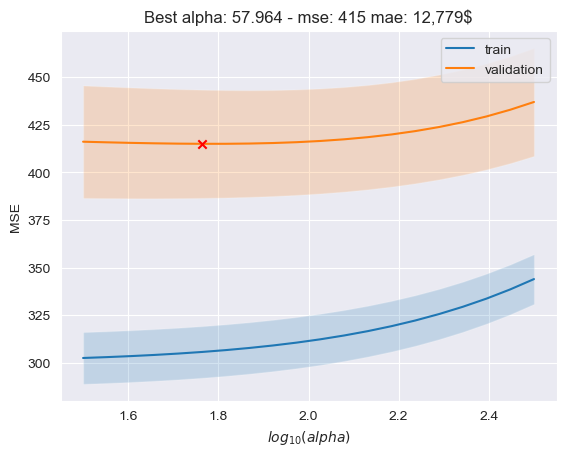

In [137]:
# Define number of Cross validations and alphas we will test in log space
grid_search_results = []
NUM_ALPHAS = 20
NUM_CROSSVALIDATIONS = 10

for run_idx in range(NUM_CROSSVALIDATIONS):
    # Split into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=run_idx)

    # Standardize features
    X_train_rescaled = scaler.fit_transform(X_train)
    X_val_rescaled = scaler.transform(X_val)

    # Grid search
    for alpha in np.logspace(1.5, 2.5, num=NUM_ALPHAS):
        # Create and fit ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_rescaled, y_train)

        # Save model and its performance on train/validation sets
        grid_search_results.append(
            {
                "model": ridge,
                "alpha": alpha,
                "run_idx": run_idx,
                "train_mse": MSE(y_train, ridge.predict(X_train_rescaled)),
                "train_mae": MAE(np.power(y_train, 2), np.power(ridge.predict(X_train_rescaled), 2)),
                "validation_mse": MSE(y_val , ridge.predict(X_val_rescaled)),
                "validation_mae": MAE(np.power(y_val, 2), np.power(ridge.predict(X_val_rescaled), 2)),
            }
        )

# Convert results to DataFrame
grid_search_results = pd.DataFrame(grid_search_results)

# Group results by alpha value
results_grouped_by_alpha = grid_search_results.groupby("alpha")

# Compute train/validation mean scores with std
mean_train = results_grouped_by_alpha.train_mse.mean()
mean_val = results_grouped_by_alpha.validation_mse.mean()
std_train = results_grouped_by_alpha.train_mse.std()
std_val = results_grouped_by_alpha.validation_mse.std()
alphas = mean_train.index.values

# Plot mean scores
plt.plot(np.log10(alphas), mean_train, label="train")
plt.plot(np.log10(alphas), mean_val, label="validation")

# Quantify variance with ±std curves
plt.fill_between(np.log10(alphas), mean_train - std_train, mean_train + std_train, alpha=0.2)
plt.fill_between(np.log10(alphas), mean_val - std_val, mean_val + std_val, alpha=0.2)

# Add marker for best score
best_alpha = mean_val.idxmin()
plt.scatter(np.log10(best_alpha), mean_val.min(), marker="x", c="red", zorder=10)

# Print best MSE/MAE scores
best_result = results_grouped_by_alpha.get_group(best_alpha)
plt.title(
    "Best alpha: {:.5} - mse: {:,.0f} mae: {:,.0f}$".format(
        best_alpha, best_result.validation_mse.mean(), best_result.validation_mae.mean()
    )
)

plt.xlabel("$log_{10}(alpha)$")
plt.ylabel("MSE")
plt.legend()
plt.show()

The error made on training and validation sets are close, variance for validation is a bit higher but does not indicate overfitting.

## Lasso

We chose now to iterate in a very similar way, this time fitting a Lasso regression for its capability to have null coefficients and maybe generate lower MSE. 

In [159]:
from sklearn.linear_model import Lasso

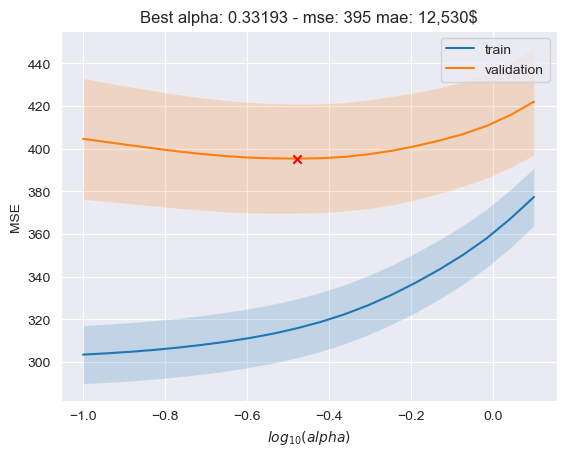

In [139]:
# Fit/validate N models
grid_search_results = []
NUM_ALPHAS = 20
NUM_CROSSVALIDATIONS = 10

for run_idx in range(NUM_CROSSVALIDATIONS):
    # Split into train/validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=run_idx)

    # Standardize features
    X_train_rescaled = scaler.fit_transform(X_train)
    X_val_rescaled = scaler.transform(X_val)

    # Grid search
    for alpha in np.logspace(-1, 0.1, num=NUM_ALPHAS):
        # Create and fit ridge regression
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train_rescaled, y_train)

        # Save model and its performance on train/validation sets
        grid_search_results.append(
            {
                "model": lasso,
                "alpha": alpha,
                "run_idx": run_idx,
                "train_mse": MSE(y_train, lasso.predict(X_train_rescaled)),
                "train_mae": MAE(np.power(y_train, 2), np.power(lasso.predict(X_train_rescaled), 2)),
                "validation_mse": MSE(y_val, lasso.predict(X_val_rescaled)),
                "validation_mae": MAE(np.power(y_val, 2), np.power(lasso.predict(X_val_rescaled), 2)),
            }
        )

# Convert results to DataFrame
grid_search_results = pd.DataFrame(grid_search_results)

# Group results by alpha value
results_grouped_by_alpha = grid_search_results.groupby("alpha")

# Compute train/validation mean scores with std
mean_train = results_grouped_by_alpha.train_mse.mean()
mean_val = results_grouped_by_alpha.validation_mse.mean()
std_train = results_grouped_by_alpha.train_mse.std()
std_val = results_grouped_by_alpha.validation_mse.std()
alphas = mean_train.index.values

# Plot mean scores
plt.plot(np.log10(alphas), mean_train, label="train")
plt.plot(np.log10(alphas), mean_val, label="validation")

# Quantify variance with ±std curves
plt.fill_between(np.log10(alphas), mean_train - std_train, mean_train + std_train, alpha=0.2)
plt.fill_between(np.log10(alphas), mean_val - std_val, mean_val + std_val, alpha=0.2)

# Add marker for best score
best_alpha = mean_val.idxmin()
plt.scatter(np.log10(best_alpha), mean_val.min(), marker="x", c="red", zorder=10)

# Print best MSE/MAE scores
best_result = results_grouped_by_alpha.get_group(best_alpha)
plt.title(
    "Best alpha: {:.5f} - mse: {:,.0f} mae: {:,.0f}$".format(
        best_alpha, best_result.validation_mse.mean(), best_result.validation_mae.mean()
    )
)

plt.xlabel("$log_{10}(alpha)$")
plt.ylabel("MSE")
plt.legend()
plt.show()

Mean MSE for Lasso regression  is a at 399 and meanb Ridge MSE is 419. They both show similar variances.
The error made on training and validation sets are close, variance for validation is a bit higher but does not indicate overfitting.

Here we fit Lasso regression to the best alpha. We chose to predict values for test data based on the entire training set, to get better predictions if possible.

In [158]:
X = df.drop(features_to_drop, axis=1)
y = df.sqrt_SalePrice

# Best alpha from crossvalidation
best_alpha = 0.33193
lasso = Lasso(alpha=best_alpha)

# Instantiating the Scaler and transforming
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)

# Fitting Lasso Regression
lasso.fit(X_rescaled,y)

# Calculating R^2 coefficient
r2_complex = lasso.score(X_rescaled, y)

In [141]:
# Prepare the test data by dropping summed column 'Total SF'
X_test = df_test.drop('Total SF', axis=1)
X_test_rescaled = scaler.transform(X_test)

# Predicting
y_test = np.power(lasso.predict(X_test_rescaled), 2)

In [142]:
# Create a new dataframe with predictions and actual values
df_pred = pd.DataFrame({'PID': df_pred, 'SalePrice': y_test})

# Save dataframe as csv
df_pred.to_csv("predictions-complex-model.csv", index=False)

We redo train and validation split here with same random_state as simple and intermediate model to get predictions errors / MAE / MSE / $R^2$

In [143]:
X_train_complex, X_val_complex, y_train_complex, y_val_complex = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)

In [144]:
# Instantiating the Scaler and transforming
scaler = StandardScaler()
X_train_complex_rescaled = scaler.fit_transform(X_train_complex)

lasso = Lasso()

# Fit Lasso
lasso.fit(X_train_complex_rescaled,y_train_complex)

# Transform validation data using the scaler
X_val_complex_rescaled = scaler.transform(X_val_complex)

# MAE, MSE, R2
y_pred_complex = lasso.predict(X_val_complex_rescaled)
mae_complex = MAE(np.power(y_val_complex,2), np.power(y_pred_complex,2))
mse_complex = MSE(y_val_complex, y_pred_complex)

print("MAE", mae_complex.astype(int))
print("R^2 coefficient complex:", r2_complex)

MAE 12681
R^2 coefficient simple: 0.9410843656469379


# Compare models

Storing model scorings and results in dataframe and lists to easily access them in iteration to create subplots

In [145]:
models = ['simple','medium','complex']
predictions = ['y_pred_simple', 'y_pred_medium', 'y_pred_complex']
validations = ['y_val_simple', 'y_val_medium', 'y_val_complex']

r2s = [r2_simple, r2_medium, r2_complex]
maes = [mae_simple, mae_medium, mae_complex]
mses = [mse_simple, mse_medium, mse_complex]

In [146]:
df_plot = pd.DataFrame({'y_pred_simple': np.power(y_pred_simple, 2), 'y_val_simple': np.power(y_val_simple, 2),
                        'y_pred_medium': np.power(y_pred_medium, 2), 'y_val_medium': np.power(y_val_medium, 2),
                        'y_pred_complex': np.power(y_pred_complex, 2), 'y_val_complex': np.power(y_val_complex, 2)
                       })

In [147]:
# Calculating error predictions in predictions dataframe
df_plot['errors_simple'] = df_plot.y_pred_simple - df_plot.y_val_simple
df_plot['errors_medium'] = df_plot.y_pred_medium - df_plot.y_val_medium
df_plot['errors_complex'] = df_plot.y_pred_complex - df_plot.y_val_complex

# Calculating max errors in all predictions to make sure plots below
# are symetrical and on same scale not to be misleading

max_error = max(df_plot['errors_simple'].abs().max(),
                df_plot['errors_medium'].abs().max(),
                df_plot['errors_complex'].abs().max())
max_error = 10000 * round(max_error/10000)

## Predictions against actual values distribution

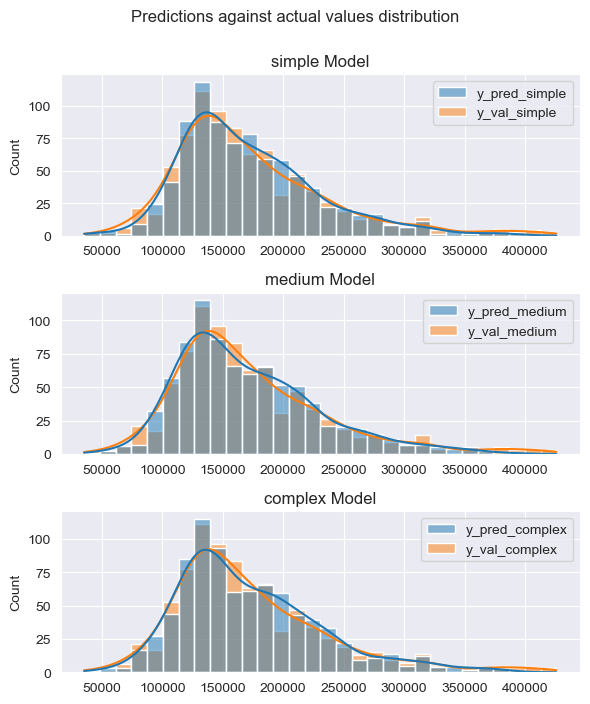

In [148]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,7))

for i, (y_pred, y_val, model) in enumerate(zip(predictions, validations, models)):
    sns.histplot(data=df_plot.loc[:, [y_pred, y_val]],
                 ax=ax[i],
                 bins=30,
                 kde=True) 
    ax[i].set_title(f'{model} Model')

plt.suptitle("Predictions against actual values distribution", y=1)
plt.tight_layout()
plt.show()

In all model, similarity between the two KDE plots suggests a close correspondence between the predicted and actual values.
* On all models, predictions are over represented around 200K
* Complex model is better in range 50-150k.

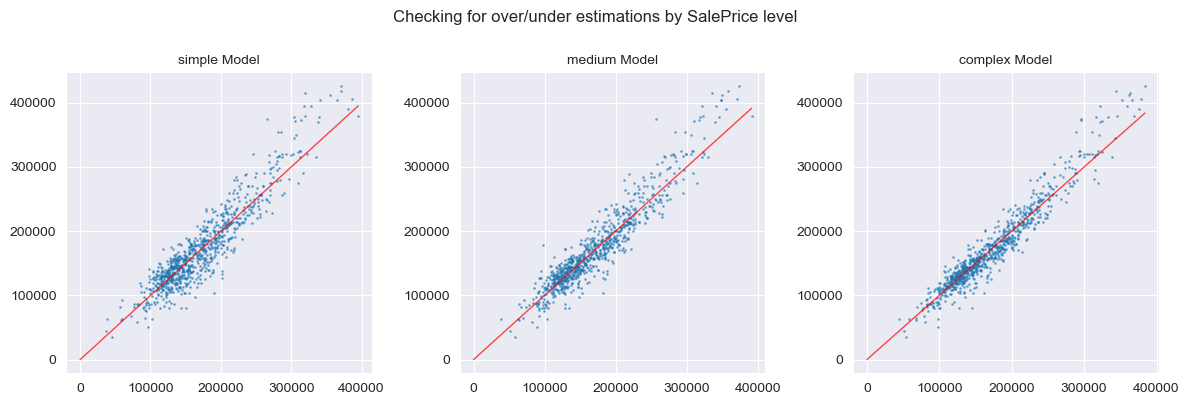

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for i, (y_pred, y_val, model) in enumerate(zip(predictions, validations, models)):
    pred = df_plot.loc[:,y_pred]
    ax[i].scatter(x=pred,
                  y=df_plot.loc[:,y_val],
                  alpha=0.5, s=1)                
    
    ax[i].set_title(f'{model} Model', fontsize=10)
    ax[i].plot([0, max(pred)], [0, max(pred)], 'r', alpha=0.7, linewidth=1)

plt.suptitle("Checking for over/under estimations by SalePrice level", y=1)
plt.tight_layout()
plt.show()

All our models have a tendency to under estimate SalePrice for values above 300'000 dollars.

On range 100-300k, errors are getting lessened accross the board as models increase in complexity. This is satisfying as increasing complexity apparently does not visibly creates a new error in model. The predictions errors above 300'000 probably means outliers exclusion based on $\sqrt SalePrice$ has removed a subset of the data which would have been helpful for generalization.

## Distribution of errors

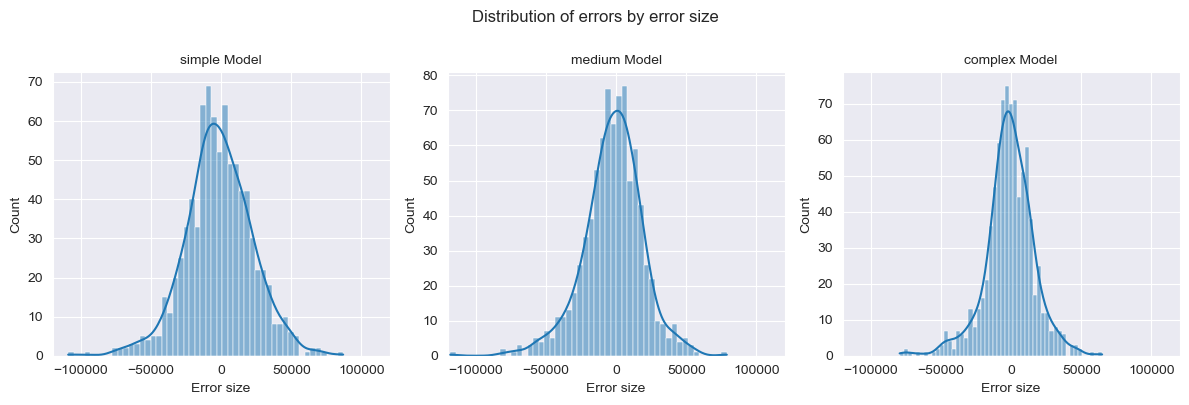

In [150]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for i, (y_pred, y_val, model) in enumerate(zip(predictions, validations, models)):    
    error = df_plot.loc[:,y_pred] - df_plot.loc[:,y_val]
    sns.histplot(x=error,
                 bins=50,
                 ax=ax[i],
                 kde=True)
    ax[i].set_xlim(-max_error, max_error)
    ax[i].set_title(f'{model} Model', fontsize=10)
    ax[i].set_xlabel("Error size")

plt.suptitle("Distribution of errors by error size", y=1)

plt.tight_layout()
plt.show()

Distribution of errors for all models has normal profile. Complex model shows could be be larger around the mean ( $\sigma^2$ could be larger).

We also find all of our models have a tendency to underestimate rather than over estimate house prices.

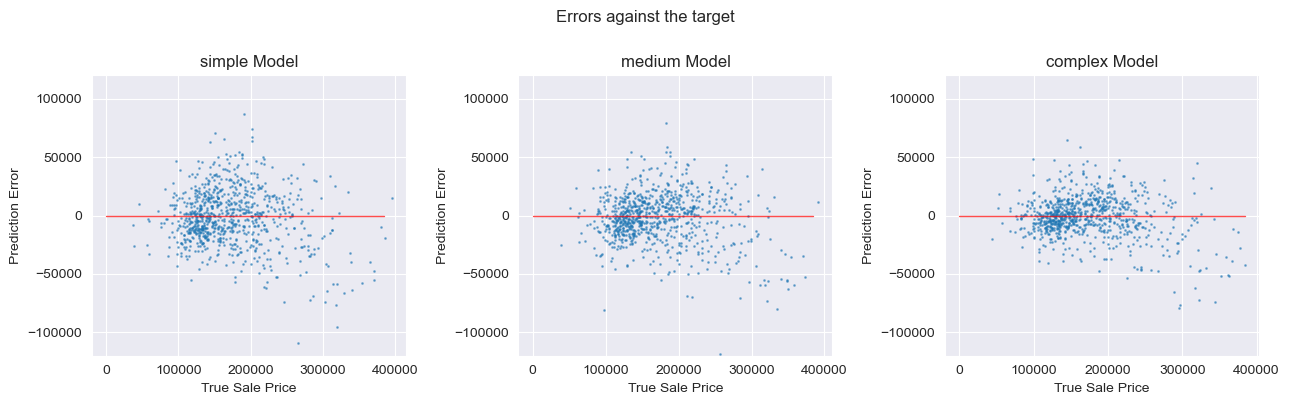

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13,4))

for i, (y_pred, y_val, model) in enumerate(zip(predictions, validations, models)):
    errors = df_plot.loc[:,y_pred] - df_plot.loc[:,y_val]

    truth = df_plot.loc[:,y_pred]
    ax[i].scatter(x=truth,
                  y=errors,
                  alpha=0.5, s=1)                
    ax[i].set_ylim(-max_error, max_error)
    
    ax[i].set_title(f'{model} Model')
    ax[i].set_xlabel("True Sale Price")
    ax[i].set_ylabel("Prediction Error")
    ax[i].plot([0, max(pred)], [0, 0], 'r', alpha=0.7, linewidth=1)

plt.suptitle("Errors against the target", y=1)
plt.tight_layout()
plt.show()

No other obvious trends detected, this confirms tendency for overestimation for Sale Price above 300k USD.

## MAE, MSE, $R^2$

In [152]:
# Define the data to be plotted
maes = np.append(maes, mae_baseline)
models = models + ['baseline']

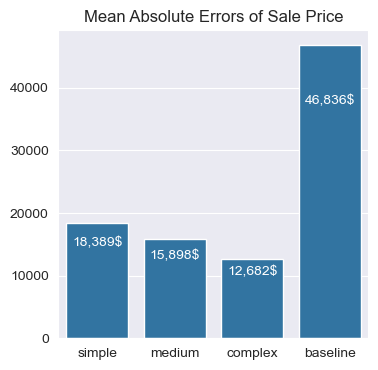

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
sns.barplot(x=models, y=maes, color="C0")

for i, mae in enumerate(maes):
    plt.text(
        x=i,             
        y=mae*0.8 ,
        s="{:,.0f}$".format(mae),
        color="white",
        horizontalalignment="center",
    )
    
plt.title('Mean Absolute Errors of Sale Price')
plt.show()

In [154]:
"{:.1%}".format(mae_complex / avg_SalePrice )

'7.0%'

MAE of complex model using lasso regression is 7% of average SalePrice in training data. It is considerably better than baseline as will also show $R^2$.

In [155]:
models = ['simple','medium','complex']

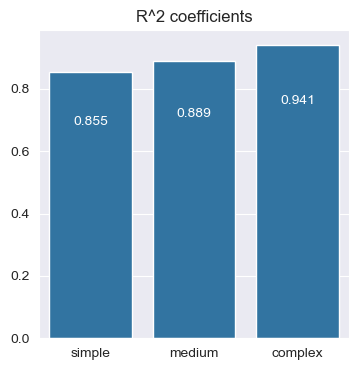

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
sns.barplot(x=models, y=r2s, color="C0")

for i, r2 in enumerate(r2s):
    plt.text(
        x=i,
        y=r2*0.8,
        s="{:.3f}".format(r2),
        color="white",
        horizontalalignment="center",
    )
plt.title('R^2 coefficients')
plt.show()

All models have $R^2$ superior to 85%. Complex model accounts for 94% of the variations in SalePrice and performs way better than the baseline.

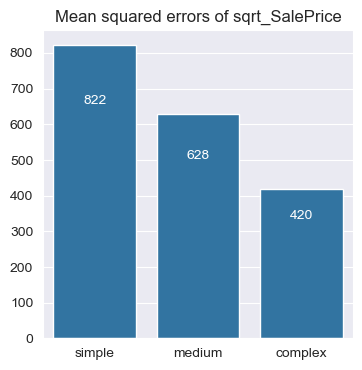

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
sns.barplot(x=models, y=mses, color="C0")

for i, mse in enumerate(mses):
    plt.text(
        x=i,
        y=mse*0.8,
        s="{:.0f}".format(mse),
        color="white",
        horizontalalignment="center",
    )
plt.title('Mean squared errors of sqrt_SalePrice')
plt.show()

Our complex model is also the one minimizing sum of squared errors, which is ultimately the goal for linear regression.

# Predictions

Screenshot from submitting CSVs here https://exts-p3review.herokuapp.com/

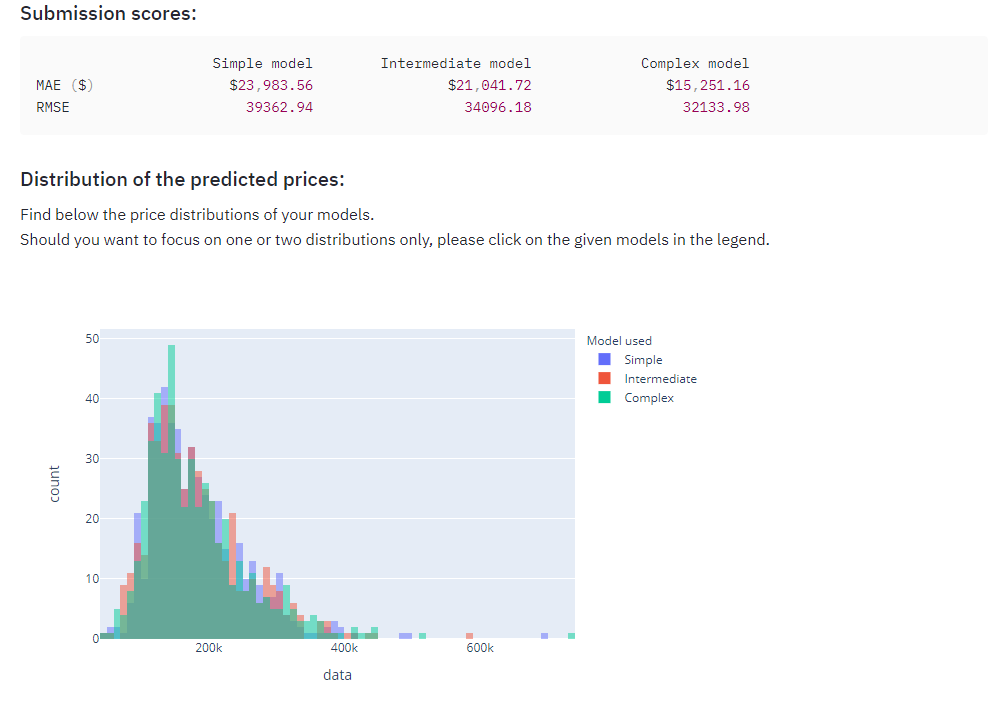